In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# STEP 2: Load the dataset
import pandas as pd
import os

# Update the filename below if it's named differently!
file_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"

# List the contents of the directory
print(f"Contents of directory: {file_path}")
for item in os.listdir(file_path):
    print(item)

# Once you know the name of the CSV file, uncomment the lines below and update the file_path
# file_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/your_csv_file_name.csv" # Replace with the actual file name
# df = pd.read_csv(file_path)

# STEP 3: Preview the dataset
# print("✅ Dataset loaded successfully!")
# print(df.head())

Contents of directory: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files
sample_images
multimodal_test_public.tsv
multimodal_validate.tsv
multimodal_train.tsv
bagged_cnn_model.pth
sample_100.tsv


In [ ]:
import pandas as pd
import os

# Load the training TSV
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files" # Corrected path to extracted files
train_path = os.path.join(extract_path, "multimodal_train.tsv")
df = pd.read_csv(train_path, sep='\t', on_bad_lines='skip') # Added on_bad_lines='skip'

# Only keep rows with valid id and 2-way label
df = df[df['2_way_label'].isin([0, 1])]
df = df[df['id'].notnull()] # Changed from image_id to id

# Create full image path
image_dir = os.path.join(extract_path, "sample_images")  # adjust if folder name differs
df['image_path'] = df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")) # Changed from image_id to id
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]

# Sample exactly 50k
# Get the current number of rows after filtering
current_rows = len(df)
# Sample the maximum available rows
df = df.sample(n=current_rows, random_state=42).reset_index(drop=True)


print("✅ Final dataset size:", len(df))

/tmp/ipython-input-2750380516.py:7: DtypeWarning: Columns (2,4,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_path, sep='\t', on_bad_lines='skip') # Added on_bad_lines='skip'


✅ Final dataset size: 224


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=True).features
mobilenet.to(device).eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except Exception as e:
        print(f"Image error: {e}")
        return None

# Run feature extraction
image_features = []
valid_indices = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    feat = extract_image_features(row['image_path'])
    if feat is not None:
        image_features.append(feat)
        valid_indices.append(i)

df = df.iloc[valid_indices].reset_index(drop=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 137MB/s]
 63%|██████▎   | 142/224 [00:31<00:18,  4.42it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


 80%|███████▉  | 179/224 [00:37<00:07,  6.31it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 224/224 [00:42<00:00,  5.31it/s]


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device).eval()

def extract_text_features(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.pooler_output.cpu().numpy()[0]

# Run text feature extraction
text_features = []
for text in tqdm(df['clean_title']):
    try:
        text_features.append(extract_text_features(text))
    except:
        text_features.append(np.zeros(768))  # fallback in case of tokenizer error


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  0%|          | 0/222 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 222/222 [00:22<00:00,  9.75it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

X = np.hstack([np.array(image_features), np.array(text_features)])
y = df['2_way_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Final Accuracy:", round(acc * 100, 2), "%")
print(classification_report(y_test, y_pred))


✅ Final Accuracy: 86.67 %
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.85      0.92      0.88        24

    accuracy                           0.87        45
   macro avg       0.87      0.86      0.86        45
weighted avg       0.87      0.87      0.87        45



<Figure size 600x600 with 0 Axes>

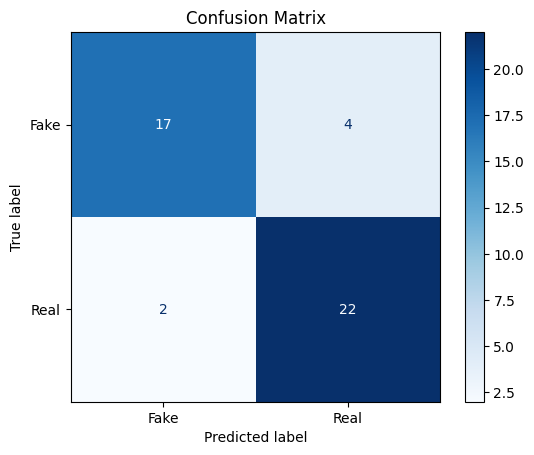

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
import joblib
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Save the model
model_path = "/content/drive/MyDrive/fakeddit_mlp_model.pkl"
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/fakeddit_mlp_model.pkl


In [ ]:
import joblib
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Save the model
model_path = "/content/drive/MyDrive/fakeddit_mlp_model.pkl" # You can change the filename if you like
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/fakeddit_mlp_model.pkl


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Replace 'your_model_folder' with the actual name of the folder in your Drive
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "fakeddit_mlp_model.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/models/fakeddit_mlp_model.pkl


In [ ]:
# Load the validation TSV
validate_path = os.path.join(extract_path, "multimodal_validate.tsv")
df_validate = pd.read_csv(validate_path, sep='\t', on_bad_lines='skip')
print("✅ Validation dataset loaded successfully!")
print(df_validate.head())

✅ Validation dataset loaded successfully!
            author                              clean_title   created_utc  \
0  singingdart7854               my xbox controller says hi  1.567436e+09   
1        mandal0re           new image from the mandalorian  1.567745e+09   
2    HE_WHO_DRUELS            say hello to my little friend  1.461468e+09   
3           eNaRDe               watch your step little one  1.408047e+09   
4   Thebubster2001  this tree i found with a solo cup on it  1.558186e+09   

        domain  hasImage       id  \
0    i.redd.it      True   cypw96   
1  i.imgur.com      True   d0bzlq   
2          NaN      True  d2ezoob   
3          NaN      True  cjqctpw   
4    i.redd.it      True   bq3yuk   

                                           image_url linked_submission_id  \
0  https://preview.redd.it/l0ga0tug17k31.jpg?widt...                  NaN   
1  https://external-preview.redd.it/VX7bXDu9Gl8UZ...                  NaN   
2                     http://i.imgur.com/

In [ ]:
# Load the test_public TSV
test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
df_test_public = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
print("✅ Test public dataset loaded successfully!")
print(df_test_public.head())

✅ Test public dataset loaded successfully!
                author                                        clean_title  \
0         trustbytrust                                          stargazer   
1                  NaN                                               yeah   
2             chaseoes  pd phoenix car thief gets instructions from yo...   
3            SFepicure  as trump accuses iran he has one problem his o...   
4  fragments_from_Work                                believers hezbollah   

    created_utc       domain  hasImage       id  \
0  1.425139e+09          NaN      True  cozywbv   
1  1.438173e+09          NaN      True  ctk61yw   
2  1.560492e+09    abc15.com      True   c0gl7r   
3  1.560606e+09  nytimes.com      True   c0xdqy   
4  1.515139e+09  i.imgur.com      True   7o9rmx   

                                           image_url linked_submission_id  \
0                     http://i.imgur.com/BruWKDi.jpg               2xct9d   
1                     http://i.im

In [ ]:
import os
import requests
from tqdm import tqdm

# Create folder to save images
# os.makedirs("sample_images", exist_ok=True) # Images are already in drive

# Download images from sample - Images are already available locally
# for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)): # Corrected df_sample to df
#     try:
#         img_url = row['image_url']
#         img_id = row['id']
#         img_path = f"sample_images/{img_id}.jpg"

#         response = requests.get(img_url, timeout=10)
#         if response.status_code == 200:
#             with open(img_path, 'wb') as f:
#                 f.write(response.content)
#     except Exception as e:
#         print(f"Error downloading {img_url}: {e}")

In [ ]:
# Preprocess validation data
# Only keep rows with valid id and 2-way label
df_validate = df_validate[df_validate['2_way_label'].isin([0, 1])]
df_validate = df_validate[df_validate['id'].notnull()]

# Create full image path
image_dir = os.path.join(extract_path, "sample_images")
df_validate['image_path'] = df_validate['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df_validate = df_validate[df_validate['image_path'].apply(lambda x: os.path.exists(x))]

print("✅ Validation dataset preprocessed.")
print("Filtered validation dataset size:", len(df_validate))

✅ Validation dataset preprocessed.
Filtered validation dataset size: 0


In [ ]:
import pandas as pd
import os
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import joblib

# Define paths
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"
sample_tsv_path = os.path.join(extract_path, "sample_100.tsv")
image_dir = os.path.join(extract_path, "sample_images")
model_path = "/content/drive/MyDrive/models/fakeddit_mlp_model.pkl"

# Load the sample TSV
df_sample = pd.read_csv(sample_tsv_path, sep='\t', on_bad_lines='skip')

# Create full image path
df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Filter out rows where image file does not exist
df_sample = df_sample[df_sample['image_path'].apply(lambda x: os.path.exists(x))]

print(f"✅ Loaded sample data with {len(df_sample)} images.")

# Load the trained model
clf = joblib.load(model_path)
print("✅ Trained model loaded.")

# Load the pre-trained image and text models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(pretrained=True).features
mobilenet.to(device).eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device).eval()


# Define feature extraction functions (same as before)
def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except Exception as e:
        print(f"Image error: {e}")
        return None

def extract_text_features(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.pooler_output.cpu().numpy()[0]

# Extract features from sample data and collect valid rows
image_features_sample = []
text_features_sample = []
valid_rows = []

print("Extracting features from sample data...")
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    img_feat = extract_image_features(row['image_path'])
    if img_feat is not None:
        try:
            text_feat = extract_text_features(row['clean_title'])
            image_features_sample.append(img_feat)
            text_features_sample.append(text_feat)
            valid_rows.append(row)
        except:
            # Handle cases where text feature extraction might fail
            print(f"Text error for id {row['id']}")
            pass # Skip this sample if text feature extraction fails

# Create a new DataFrame from valid rows
df_sample_filtered = pd.DataFrame(valid_rows).reset_index(drop=True)

# Combine features
X_sample = np.hstack([np.array(image_features_sample), np.array(text_features_sample)])

# Make predictions
predictions = clf.predict(X_sample)

# Map predictions to labels
prediction_labels = ["Fake" if p == 0 else "Real" for p in predictions]

# Create a DataFrame with image file names and predictions
results_df = pd.DataFrame({
    'image_file': df_sample_filtered['image_path'].apply(lambda x: os.path.basename(x)),
    'prediction': prediction_labels
})

print("\n✅ Predictions made successfully.")
display(results_df)

✅ Loaded sample data with 140 images.
✅ Trained model loaded.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features from sample data...


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
 90%|█████████ | 126/140 [00:17<00:01,  9.50it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 140/140 [00:19<00:00,  7.07it/s]


✅ Predictions made successfully.


image_file prediction
0     auqei3.jpg       Real
1     aznhxl.jpg       Fake
2     3jcpgv.jpg       Real
3     dd7jdn.jpg       Real
4     5p4feg.jpg       Real
..           ...        ...
134  cfgab9n.jpg       Fake
135   db5t7h.jpg       Fake
136   ddpd4o.jpg       Real
137   dk5ocd.jpg       Real
138   db3tw3.jpg       Real

[139 rows x 2 columns]

In [ ]:
print("First 5 rows of preprocessed validation DataFrame (df_validate_filtered):")
display(df_validate_filtered.head())

print("\nFirst 5 rows of preprocessed test public DataFrame (df_test_public_filtered):")
display(df_test_public_filtered.head())

print("\nFiles in the sample_images directory:")
import os
image_dir = os.path.join(extract_path, "sample_images")
for i, filename in enumerate(os.listdir(image_dir)):
    if i < 20: # Display only the first 20 files to keep the output manageable
        print(filename)
    else:
        print("...")
        break

First 5 rows of preprocessed validation DataFrame (df_validate_filtered):


Empty DataFrame
Columns: [author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label, image_path]
Index: []


First 5 rows of preprocessed test public DataFrame (df_test_public_filtered):


Empty DataFrame
Columns: [author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label, image_path]
Index: []


Files in the sample_images directory:
80u91r.jpg
dd7jdn.jpg
3jcpgv.jpg
aznhxl.jpg
cabjuw.jpg
auqei3.jpg
5p4feg.jpg
36wso6.jpg
9bnpz3.jpg
c905kn.jpg
7zyw11.jpg
4pnank.jpg
5r2rdx.jpg
6q267m.jpg
4qk46e.jpg
3f9vmx.jpg
1djpde.jpg
c3vtdn.jpg
554wor.jpg
8fw91j.jpg
...


# Task
Download images from the 'image_url' column in the "Fakeddit Project Files/dataset/multimodal_validate.tsv" and "Fakeddit Project Files/dataset/multimodal_test_public.tsv" files and save them to the "Fakeddit Project Files/sample_images" directory, using the 'id' column as the filename (with a .jpg extension).

## Load data

### Subtask:
Load the `multimodal_validate.tsv` and `multimodal_test_public.tsv` files into dataframes.


**Reasoning**:
Load the validation and test public datasets into pandas DataFrames.



In [ ]:
# Load the validation TSV
validate_path = os.path.join(extract_path, "multimodal_validate.tsv")
df_validate = pd.read_csv(validate_path, sep='\t', on_bad_lines='skip')
print("✅ Validation dataset loaded successfully!")
display(df_validate.head())

# Load the test_public TSV
test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
df_test_public = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
print("✅ Test public dataset loaded successfully!")
display(df_test_public.head())

✅ Validation dataset loaded successfully!


author                              clean_title   created_utc  \
0  singingdart7854               my xbox controller says hi  1.567436e+09   
1        mandal0re           new image from the mandalorian  1.567745e+09   
2    HE_WHO_DRUELS            say hello to my little friend  1.461468e+09   
3           eNaRDe               watch your step little one  1.408047e+09   
4   Thebubster2001  this tree i found with a solo cup on it  1.558186e+09   

        domain  hasImage       id  \
0    i.redd.it      True   cypw96   
1  i.imgur.com      True   d0bzlq   
2          NaN      True  d2ezoob   
3          NaN      True  cjqctpw   
4    i.redd.it      True   bq3yuk   

                                           image_url linked_submission_id  \
0  https://preview.redd.it/l0ga0tug17k31.jpg?widt...                  NaN   
1  https://external-preview.redd.it/VX7bXDu9Gl8UZ...                  NaN   
2                     http://i.imgur.com/F1Zbl3D.jpg               4g6bp9   
3                     http://i.imgur.com/KRyMjn1.jpg               2diyh3   
4  https://preview.redd.it/bxp58zf01zy21.jpg?widt...                  NaN   

   num_comments  score          subreddit  \
0           4.0     25  mildlyinteresting   
1           5.0     21   photoshopbattles   
2           NaN     10   psbattle_artwork   
3           NaN      1   psbattle_artwork   
4           8.0      6  mildlyinteresting   

                                      title  upvote_ratio  2_way_label  \
0                My Xbox controller says hi          0.72            1   
1  PsBattle: New image from The Mandalorian          0.92            1   
2            Say hello to my little friend!           NaN            0   
3                Watch your step little one           NaN            0   
4   This tree I found with a solo cup on it          0.62            1   

   3_way_label  6_way_label  
0            0            0  
1            0            0  
2            2            4  
3            2            4  
4            0            0

✅ Test public dataset loaded successfully!


author                                        clean_title  \
0         trustbytrust                                          stargazer   
1                  NaN                                               yeah   
2             chaseoes  pd phoenix car thief gets instructions from yo...   
3            SFepicure  as trump accuses iran he has one problem his o...   
4  fragments_from_Work                                believers hezbollah   

    created_utc       domain  hasImage       id  \
0  1.425139e+09          NaN      True  cozywbv   
1  1.438173e+09          NaN      True  ctk61yw   
2  1.560492e+09    abc15.com      True   c0gl7r   
3  1.560606e+09  nytimes.com      True   c0xdqy   
4  1.515139e+09  i.imgur.com      True   7o9rmx   

                                           image_url linked_submission_id  \
0                     http://i.imgur.com/BruWKDi.jpg               2xct9d   
1                     http://i.imgur.com/JRZT727.jpg               3f0h7o   
2  https://external-preview.redd.it/1A2_4VwgS8Qd2...                  NaN   
3  https://external-preview.redd.it/9BKRcgvaobpTo...                  NaN   
4  https://external-preview.redd.it/rbwXHncnjVh51...                  NaN   

   num_comments  score          subreddit  \
0           NaN      3   psbattle_artwork   
1           NaN      2   psbattle_artwork   
2           2.0     16        nottheonion   
3           4.0     45        neutralnews   
4          40.0    285  propagandaposters   

                                               title  upvote_ratio  \
0                                         stargazer            NaN   
1                                               yeah           NaN   
2  PD: Phoenix car thief gets instructions from Y...          0.89   
3  As Trump Accuses Iran, He Has One Problem: His...          0.78   
4                       "Believers" - Hezbollah 2011          0.95   

   2_way_label  3_way_label  6_way_label  
0            0            2            4  
1            0            2            4  
2            1            0            0  
3            1            0            0  
4            0            1            5

## Identify image urls and filenames

### Subtask:
Extract the 'image_url' and 'id' columns from both dataframes (`df_validate` and `df_test_public`). The 'id' will be used to construct the filename for the downloaded image.


**Reasoning**:
Extract the required columns and filter out rows with missing image URLs from both dataframes.



In [ ]:
# Create a new DataFrame with only 'id' and 'image_url' for validation data
df_validate_images = df_validate[['id', 'image_url']].copy()

# Remove rows where 'image_url' is null or empty
df_validate_images.dropna(subset=['image_url'], inplace=True)
df_validate_images = df_validate_images[df_validate_images['image_url'].str.strip() != '']

print("✅ Extracted and filtered validation image data.")
display(df_validate_images.head())
print(f"Filtered validation image data size: {len(df_validate_images)}")

# Create a new DataFrame with only 'id' and 'image_url' for test public data
df_test_public_images = df_test_public[['id', 'image_url']].copy()

# Remove rows where 'image_url' is null or empty
df_test_public_images.dropna(subset=['image_url'], inplace=True)
df_test_public_images = df_test_public_images[df_test_public_images['image_url'].str.strip() != '']

print("\n✅ Extracted and filtered test public image data.")
display(df_test_public_images.head())
print(f"Filtered test public image data size: {len(df_test_public_images)}")

✅ Extracted and filtered validation image data.


id                                          image_url
0   cypw96  https://preview.redd.it/l0ga0tug17k31.jpg?widt...
1   d0bzlq  https://external-preview.redd.it/VX7bXDu9Gl8UZ...
2  d2ezoob                     http://i.imgur.com/F1Zbl3D.jpg
3  cjqctpw                     http://i.imgur.com/KRyMjn1.jpg
4   bq3yuk  https://preview.redd.it/bxp58zf01zy21.jpg?widt...

Filtered validation image data size: 59169

✅ Extracted and filtered test public image data.


id                                          image_url
0  cozywbv                     http://i.imgur.com/BruWKDi.jpg
1  ctk61yw                     http://i.imgur.com/JRZT727.jpg
2   c0gl7r  https://external-preview.redd.it/1A2_4VwgS8Qd2...
3   c0xdqy  https://external-preview.redd.it/9BKRcgvaobpTo...
4   7o9rmx  https://external-preview.redd.it/rbwXHncnjVh51...

Filtered test public image data size: 59163


## Define download function

### Subtask:
Create a Python function that takes an image URL and a file path as input, downloads the image from the URL, and saves it to the specified file path. Include error handling for download failures.


**Reasoning**:
Define a function to download an image from a URL and save it to a specified path, including error handling.



## Create target directory

### Subtask:
Ensure the `sample_images` directory exists within the `Fakeddit Project Files` directory.


In [ ]:
import os

# Define the path to the Fakeddit Project Files directory
extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"

# Construct the full path to the sample_images directory
image_dir = os.path.join(extract_path, "sample_images")

# Create the directory if it doesn't exist
os.makedirs(image_dir, exist_ok=True)

print(f"✅ Ensured directory exists: {image_dir}")

✅ Ensured directory exists: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images


**Reasoning**:
Iterate through the validation and test public dataframes, download each image using the previously defined function, and save it to the target directory with the correct filename.



✅ Retrained oversampled model loaded successfully from: /content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl

The retrained oversampled model predicts for '3jcpgv.jpg': Real


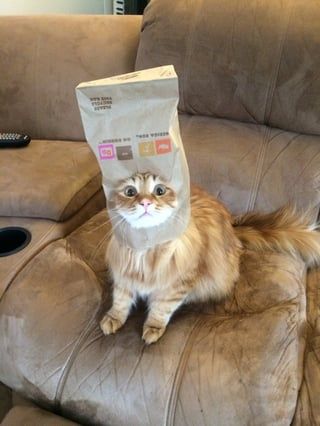

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import joblib
import os

# Ensure models and classifier are loaded (assuming they were loaded in previous cells)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mobilenet = models.mobilenet_v2(pretrained=True).features.to(device).eval()
# img_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert = BertModel.from_pretrained("bert-base-uncased").to(device).eval()

# --- Load the Retrained Oversampled Model ---
model_path_retrained = "/content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl" # Path to your saved model

clf_retrained_oversample = None # Initialize to None
if os.path.exists(model_path_retrained):
    clf_retrained_oversample = joblib.load(model_path_retrained)
    print(f"✅ Retrained oversampled model loaded successfully from: {model_path_retrained}")
else:
    print(f"❌ Retrained oversampled model file not found at: {model_path_retrained}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")


def extract_image_features(img_path):
    """
    Extracts image features using MobileNetV2.
    Assumes mobilenet and img_transform are defined globally or accessible.
    """
    # Ensure mobilenet and img_transform are defined and on the correct device
    if 'mobilenet' not in globals() or 'img_transform' not in globals() or 'device' not in globals():
        print("Error: MobileNet or image transform not defined.")
        return None

    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except Exception as e:
        print(f"Image error: {e}")
        return None


def extract_text_features(text):
    """
    Extracts text features using BERT.
    Assumes tokenizer and bert are defined globally or accessible.
    """
    # Ensure tokenizer and bert are defined and on the correct device
    if 'tokenizer' not in globals() or 'bert' not in globals() or 'device' not in globals():
         print("Error: BERT tokenizer or model not defined.")
         return np.zeros(768) # Return zero vector if BERT is not available

    try:
        tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = bert(**tokens)
        return outputs.pooler_output.cpu().numpy()[0]
    except Exception as e:
        print(f"Text error: {e}")
        return np.zeros(768)  # fallback in case of tokenizer error or other issue


def predict_real_or_fake(image_path, text, model):
    """Predicts if an image is real or fake based on the image and text using a specified model.

    Args:
        image_path: The full path to the image file.
        text: The text associated with the image.
        model: The trained model object to use for prediction (e.g., MLP classifier).

    Returns:
        A string indicating whether the image is "Real" or "Fake", or None if
        feature extraction or model prediction fails.
    """
    # Extract image features
    img_feat = extract_image_features(image_path)
    # Note: extract_image_features now handles the case where mobilenet/transform are not defined
    if img_feat is None:
        print(f"Could not extract features from image: {image_path} (Feature extractor not defined?)")
        return None

    # Extract text features
    text_feat = extract_text_features(text) # extract_text_features now handles case where tokenizer/bert not defined

    # Combine features
    combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

    # Make prediction using the provided model
    try:
        prediction = model.predict(combined_features)[0]
        # Map prediction to label
        return "Fake" if prediction == 0 else "Real"
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None


# Example usage with the retrained oversampled model:
# Ensure clf_retrained_oversample is loaded
# Define an example image path and text that *should* be among the 140 images

# Using an example ID known to be in the original 224 (and likely in the 140)
example_image_id_retrained = "3jcpgv" # Example ID from a previous output
example_text_retrained = "cat with a hat" # Corresponding text

# Ensure extract_path and image_dir are defined from previous cells
if 'extract_path' in locals() and 'image_dir' in locals():
    example_image_path_retrained = os.path.join(image_dir, f"{example_image_id_retrained}.jpg")

    if clf_retrained_oversample is not None and os.path.exists(example_image_path_retrained):
        prediction_result_retrained = predict_real_or_fake(example_image_path_retrained, example_text_retrained, clf_retrained_oversample)

        if prediction_result_retrained:
            print(f"\nThe retrained oversampled model predicts for '{os.path.basename(example_image_path_retrained)}': {prediction_result_retrained}")

            # Optional: Display the image
            try:
                img = Image.open(example_image_path_retrained)
                display(img)
            except Exception as e:
                print(f"Could not display image: {e}")
    elif not os.path.exists(example_image_path_retrained):
         print(f"\nError: Example image file not found at: {example_image_path_retrained}")
         print("Please check if the image file exists in the sample_images directory.")
    else:
        print("\nRetrained oversampled model was not loaded successfully. Cannot make predictions.")

else:
    print("\nError: 'extract_path' or 'image_dir' not defined. Cannot construct example image path.")

✅ Sample data loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_100.tsv
Filtered sample data to 140 samples with existing images.
✅ Retrained oversampled model loaded successfully from: /content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl

Predicting for sample with ID: 6tlk99
Text: charlottesville photo man shouting angrily at white supremacist rally insists he is not an angry racist


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The retrained oversampled model predicts this image is: Real


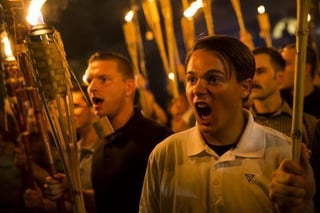

In [ ]:
import os
from PIL import Image
from IPython.display import display
import pandas as pd # Import pandas to load the dataframe
import joblib # Import joblib to load the model
import torch # Import torch
from torchvision import models, transforms # Import torchvision components
from transformers import BertTokenizer, BertModel # Import BERT components
import numpy as np # Import numpy


# --- Load the sample data ---
# Assuming extract_path is defined from previous cells
if 'extract_path' in locals():
    sample_tsv_path = os.path.join(extract_path, "sample_100.tsv")
    try:
        df_sample = pd.read_csv(sample_tsv_path, sep='\t', on_bad_lines='skip')
        print(f"✅ Sample data loaded successfully from: {sample_tsv_path}")

        # Ensure 'image_path' column exists in df_sample
        # Assuming image_dir is defined from previous cells
        if 'image_dir' in locals():
            df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
            # Filter out rows where image file does not exist
            df_sample = df_sample[df_sample['image_path'].apply(lambda x: os.path.exists(x))].reset_index(drop=True)
            print(f"Filtered sample data to {len(df_sample)} samples with existing images.")
        else:
            print("Error: 'image_dir' not defined. Cannot create 'image_path' or filter df_sample.")
            df_sample = pd.DataFrame() # Set df_sample to empty if image_dir is missing

    except FileNotFoundError:
        print(f"❌ Sample data file not found at: {sample_tsv_path}")
        df_sample = pd.DataFrame() # Set df_sample to empty if file not found
    except Exception as e:
        print(f"Error loading or processing sample data: {e}")
        df_sample = pd.DataFrame() # Set df_sample to empty on other errors
else:
    print("Error: 'extract_path' not defined. Cannot load sample data.")
    df_sample = pd.DataFrame() # Set df_sample to empty if extract_path is missing


# --- Load the Retrained Oversampled Model ---
model_path_retrained = "/content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl" # Path to your saved model

clf_retrained_oversample = None # Initialize to None
if os.path.exists(model_path_retrained):
    try:
        clf_retrained_oversample = joblib.load(model_path_retrained)
        print(f"✅ Retrained oversampled model loaded successfully from: {model_path_retrained}")
    except Exception as e:
        print(f"❌ Error loading model from {model_path_retrained}: {e}")
        clf_retrained_oversample = None
else:
    print(f"❌ Retrained oversampled model file not found at: {model_path_retrained}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")
    clf_retrained_oversample = None # Ensure it's None if not found


# --- Load Feature Extractors (MobileNet and BERT) ---
# Ensure MobileNet and BERT models and preprocessors/tokenizers are loaded
# Check if they are already in the global scope from previous cells
if 'mobilenet' not in globals() or 'img_transform' not in globals() or 'device' not in globals():
    print("Loading MobileNet model and preprocessor...")
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features # Use weights parameter
        mobilenet.to(device).eval()
        img_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        print("✅ MobileNetV2 model and preprocessor loaded.")
    except Exception as e:
        print(f"❌ Error loading MobileNetV2: {e}")
        mobilenet = None
        img_transform = None
        device = "cpu" # Fallback device


if 'tokenizer' not in globals() or 'bert' not in globals():
    print("Loading BERT model and tokenizer...")
    try:
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        bert = BertModel.from_pretrained("bert-base-uncased")
        bert.to(device).eval()
        print("✅ BERT model and tokenizer loaded.")
    except Exception as e:
        print(f"❌ Error loading BERT: {e}")
        tokenizer = None
        bert = None

# --- Define Feature Extraction Functions ---
def extract_image_features(img_path):
    """
    Extracts image features using MobileNetV2.
    Assumes mobilenet, img_transform, and device are defined globally or accessible.
    """
    if mobilenet is None or img_transform is None:
        print("Error: MobileNet or image transform not loaded.")
        return None

    try:
        img = Image.open(img_path).convert("RGB")
        img = img_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet(img)
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        return feat.view(-1).cpu().numpy()
    except FileNotFoundError:
        print(f"Image file not found for feature extraction: {img_path}")
        return None
    except Exception as e:
        print(f"Image error during feature extraction for {img_path}: {e}")
        return None


def extract_text_features(text):
    """
    Extracts text features using BERT.
    Assumes tokenizer, bert, and device are defined globally or accessible.
    """
    if tokenizer is None or bert is None:
         print("Error: BERT tokenizer or model not loaded.")
         return np.zeros(768) # Return zero vector if BERT is not available

    try:
        tokens = tokenizer(str(text), return_tensors='pt', padding=True, truncation=True, max_length=64) # Ensure text is string
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = bert(**tokens)
        return outputs.pooler_output.cpu().numpy()[0]
    except Exception as e:
        print(f"Text error during feature extraction for '{str(text)[:50]}...': {e}") # Ensure text is string for slicing
        return np.zeros(768)  # fallback in case of tokenizer error or other issue


# --- Define Prediction Function ---
def predict_real_or_fake(image_path, text, model):
    """Predicts if an image is real or fake based on the image and text using a specified model.

    Args:
        image_path: The full path to the image file.
        text: The text associated with the image.
        model: The trained model object to use for prediction (e.g., MLP classifier).

    Returns:
        A string indicating whether the image is "Real" or "Fake", or None if
        feature extraction or model prediction fails or model is not provided/loaded.
    """
    if model is None:
        print("Error: Model not loaded. Cannot make prediction.")
        return None

    # Extract image features
    img_feat = extract_image_features(image_path)
    if img_feat is None:
        print(f"Could not extract image features from: {image_path}")
        return None

    # Extract text features
    text_feat = extract_text_features(text)
    # Note: extract_text_features returns zeros on error, so we check if it's not None (which it won't be unless the function itself fails before returning)
    if text_feat is None: # This check is mostly for robustness, as extract_text_features currently returns np.zeros on error
        print(f"Could not extract text features for text: '{str(text)[:50]}...'")
        return None


    # Combine features
    # Ensure features are numpy arrays before stacking
    if isinstance(img_feat, np.ndarray) and isinstance(text_feat, np.ndarray):
        combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)
    else:
        print("Error: Feature extraction returned non-numpy array types.")
        return None


    # Make prediction using the provided model
    try:
        prediction = model.predict(combined_features)[0]
        # Map prediction to label
        return "Fake" if prediction == 0 else "Real"
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None


# --- Select a Sample and Predict ---
# Define the index of the sample you want to test
sample_index = 67 # You can change this index

# Ensure df_sample is loaded and not empty
if 'df_sample' in locals() and not df_sample.empty:

    # Ensure 'image_path' column exists in df_sample
    if 'image_path' not in df_sample.columns:
        print("Creating 'image_path' column in df_sample...")
        # Assuming image_dir and extract_path are defined in previous cells
        if 'image_dir' in locals() and 'extract_path' in locals():
             image_dir = os.path.join(extract_path, "sample_images")
             df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
             # Filter out rows where image file does not exist
             df_sample = df_sample[df_sample['image_path'].apply(lambda x: os.path.exists(x))].reset_index(drop=True)
             print(f"Filtered df_sample to {len(df_sample)} samples with existing images.")
        else:
            print("Error: 'image_dir' or 'extract_path' not defined. Cannot create 'image_path' or filter df_sample.")


    # Ensure 'clean_title' column exists in df_sample
    if 'clean_title' not in df_sample.columns:
         print("Error: Missing required column 'clean_title' in df_sample.")
    elif 'image_path' not in df_sample.columns:
         print("Error: Missing required column 'image_path' in df_sample. Ensure image_dir was defined and image_path was created.")
    else:
        try:
            # Get the sample row from df_sample using the specified index
            if sample_index < len(df_sample):
                 sample = df_sample.iloc[101]

                 # Get the image path and text
                 img_path = sample['image_path']
                 sample_text = sample['clean_title']
                 sample_id = sample['id']


                 # Check if the image file exists (already filtered df_sample, but double check)
                 if os.path.exists(img_path):
                     # Use the predict_real_or_fake function
                     # This code will use clf_retrained_oversample if it's available
                     if clf_retrained_oversample is not None:
                          print(f"\nPredicting for sample with ID: {sample_id}")
                          print(f"Text: {sample_text}")

                          prediction_result = predict_real_or_fake(img_path, sample_text, clf_retrained_oversample) # Use the retrained model

                          if prediction_result:
                              print(f"The retrained oversampled model predicts this image is: {prediction_result}")

                              # Display the image
                              try:
                                  img = Image.open(img_path)
                                  display(img)
                              except Exception as e:
                                  print(f"Could not display image: {e}")
                          else:
                              print(f"\nCould not get prediction result for sample with ID: {sample_id}")

                     else:
                         print("\nRetrained oversampled model was not loaded successfully. Cannot make predictions.")


                 else:
                     print(f"\nImage file not found for sample with ID: {sample_id} at path: {img_path}")
                     print(f"Text: {sample_text}")
                     print("This sample might have been filtered out because the image file was missing.")

            else:
                print(f"\nError: sample_index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")

        except KeyError as e:
            print(f"Error accessing column: {e}. Please check if the necessary columns ('id', 'image_path', 'clean_title') exist in df_sample.")
        except NameError:
             print("Error: Necessary variables like 'extract_path', 'image_dir', 'predict_real_or_fake' are not defined. Please run previous setup cells.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

else:
    print("Error: df_sample DataFrame is not loaded or is empty. Please check the loading steps.")

In [ ]:
# Ensure df_sample is loaded and filtered for existing image paths
# (This step is assumed to have been done in a previous cell, e.g., f953be9f)

if 'df_sample' in locals():
    print(f"You have {len(df_sample)} sample images available.")
else:
    print("The df_sample DataFrame is not loaded. Please run the cell that loads and preprocesses the sample data first.")

You have 140 sample images available.


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Replace 'your_model_folder' with the actual name of the folder in your Drive
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "fakeddit_mlp_model.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

MessageError: Error: credential propagation was unsuccessful

In [ ]:
df['2_way_label'].value_counts()


2_way_label
1.0    129
0.0     93
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Assume df is your DataFrame with '2_way_label' column
# If your DataFrame is named differently, please update 'df' below

if 'df' in locals() and not df.empty:
    print("Original class distribution:")
    display(df['2_way_label'].value_counts())

    # Separate majority and minority classes
    df_majority = df[df['2_way_label'] == 1.0]
    df_minority = df[df['2_way_label'] == 0.0]

    # Determine the number of samples in the majority class
    majority_class_size = len(df_majority)
    print(f"\nOversampling minority class to {majority_class_size} samples.")


    # Oversample the minority class
    # Use replace=True to sample with replacement
    # Use n=majority_class_size to match the number of majority class samples
    # Use random_state for reproducibility
    df_minority_oversampled = resample(df_minority,
                                       replace=True,     # sample with replacement
                                       n_samples=majority_class_size,    # to match majority class size
                                       random_state=42) # for reproducible results

    # Concatenate the oversampled minority class with the majority class
    df_balanced_oversampled = pd.concat([df_majority, df_minority_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nBalanced class distribution (Oversampled):")
    display(df_balanced_oversampled['2_way_label'].value_counts())

    # Now you can use df_balanced_oversampled for training your model
    # For example, assign it back to df if you want to replace the original DataFrame:
    # df = df_balanced_oversampled

else:
    print("The df DataFrame is not loaded or is empty. Please load your data first.")

Original class distribution:


2_way_label
1.0    129
0.0     93
Name: count, dtype: int64


Oversampling minority class to 129 samples.

Balanced class distribution (Oversampled):


2_way_label
1.0    129
0.0    129
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import numpy as np

# Ensure df and the feature extraction functions are available

if 'df' in locals() and not df.empty:

    print("Preparing data for training and evaluation...")

    # Extract features from the original df
    # We need to ensure we have the features for the original df first
    # Assuming this was done in previous cells (K_s4k2LlBpw_, 9da3S2N-B7Ir)
    # Re-extracting features for the original df to be safe if kernel state was reset
    print("Extracting features from the original data...")
    image_features_original = []
    text_features_original = []
    valid_indices_original = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_feat = extract_image_features(row['image_path'])
        if img_feat is not None:
            image_features_original.append(img_feat)
            try:
                text_feat = extract_text_features(row['clean_title'])
                text_features_original.append(text_feat)
                valid_indices_original.append(i)
            except:
                print(f"Text error for id {row['id']} in original data.")
                text_features_original.append(np.zeros(768))
                valid_indices_original.append(i)

    # Create a filtered DataFrame for the original data with valid features
    df_original_filtered = df.iloc[valid_indices_original].reset_index(drop=True)

    if len(image_features_original) > 0 and len(text_features_original) == len(image_features_original):
        X_original = np.hstack([np.array(image_features_original), np.array(text_features_original)])
        y_original = df_original_filtered['2_way_label'].values

        # Perform train-test split on the original, unbalanced data
        print("\nPerforming train-test split on original data...")
        X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, stratify=y_original) # Use stratify to maintain class distribution

        print("Original training set class distribution:")
        # Need to get labels for X_train to show distribution
        train_labels = pd.Series(y_train)
        display(train_labels.value_counts())

        print("\nOriginal test set class distribution:")
         # Need to get labels for X_test to show distribution
        test_labels = pd.Series(y_test)
        display(test_labels.value_counts())

        # Combine X_train and y_train for oversampling
        X_train_combined = pd.DataFrame(X_train)
        X_train_combined['label'] = y_train

        # Separate majority and minority classes in the training data
        df_train_majority = X_train_combined[X_train_combined['label'] == 1.0]
        df_train_minority = X_train_combined[X_train_combined['label'] == 0.0]

        # Oversample the minority class in the training data
        majority_size_train = len(df_train_majority)
        df_train_minority_oversampled = resample(df_train_minority,
                                               replace=True,
                                               n_samples=majority_size_train,
                                               random_state=42)

        # Combine majority class with oversampled minority class
        df_train_oversampled = pd.concat([df_train_majority, df_train_minority_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

        print("\nOversampled training set class distribution:")
        display(df_train_oversampled['label'].value_counts())

        # Separate features and labels from the oversampled training data
        X_train_oversampled = df_train_oversampled.drop('label', axis=1).values
        y_train_oversampled = df_train_oversampled['label'].values


        # Retrain the model with the oversampled training data
        print("\nRetraining the model with oversampled training data...")
        # Re-initialize or reuse the classifier
        clf_retrained_oversample = MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=200, random_state=42)

        # Train the model
        clf_retrained_oversample.fit(X_train_oversampled, y_train_oversampled)

        # Evaluate the retrained model on the original, UNBALANCED test set
        print("\nEvaluating the retrained model on the original test set...")
        y_pred_retrained_oversample = clf_retrained_oversample.predict(X_test)
        acc_retrained_oversample = accuracy_score(y_test, y_pred_retrained_oversample)

        print("✅ Retrained Model Accuracy (on original test set):", round(acc_retrained_oversample * 100, 2), "%")
        print("\nClassification Report (on original test set):")
        print(classification_report(y_test, y_pred_retrained_oversample))

    else:
        print("\nError: Feature extraction failed for original data. Cannot perform train-test split or retraining.")
        print(f"Image features count: {len(image_features_original)}, Text features count: {len(text_features_original)}")

else:
    print("The df DataFrame is not loaded or is empty. Please load your data first.")

Preparing data for training and evaluation...
Extracting features from the original data...


 64%|██████▍   | 143/224 [00:21<00:08,  9.57it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


 80%|████████  | 180/224 [00:26<00:06,  6.40it/s]

Image error: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 224/224 [00:33<00:00,  6.60it/s]


Performing train-test split on original data...
Original training set class distribution:


1.0    103
0.0     74
Name: count, dtype: int64


Original test set class distribution:


1.0    26
0.0    19
Name: count, dtype: int64


Oversampled training set class distribution:


label
1.0    103
0.0    103
Name: count, dtype: int64


Retraining the model with oversampled training data...

Evaluating the retrained model on the original test set...
✅ Retrained Model Accuracy (on original test set): 91.11 %

Classification Report (on original test set):
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        19
         1.0       0.92      0.92      0.92        26

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Using a slightly different name to distinguish it from the previous model
model_dir = "/content/drive/MyDrive/models"
model_path_retrained = os.path.join(model_dir, "fakeddit_mlp_model_retrained_oversampled.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Ensure the retrained model object exists
if 'clf_retrained_oversample' in locals():
    # Save the retrained model
    joblib.dump(clf_retrained_oversample, model_path_retrained)

    print(f"✅ Retrained model saved to: {model_path_retrained}")
else:
    print("❌ Retrained model object 'clf_retrained_oversample' not found. Please run the retraining cell first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Retrained model saved to: /content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl


✅ Sample data loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_100.tsv
Filtered sample data to 140 samples with existing images.
✅ Retrained oversampled model loaded successfully from: /content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl

For sample with ID dd7jdn:
Text: the schloegener schlinge is the biggest entrenched meander in europe
The retrained oversampled model predicts this image is: Real


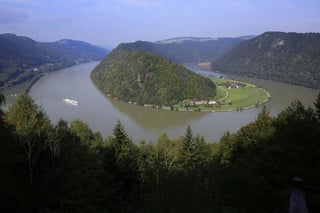

In [ ]:
import os
from PIL import Image
from IPython.display import display
import pandas as pd # Import pandas to load the dataframe
import joblib # Import joblib to load the model


# --- Load the sample data ---
# Assuming extract_path is defined from previous cells
if 'extract_path' in locals():
    sample_tsv_path = os.path.join(extract_path, "sample_100.tsv")
    try:
        df_sample = pd.read_csv(sample_tsv_path, sep='\t', on_bad_lines='skip')
        print(f"✅ Sample data loaded successfully from: {sample_tsv_path}")

        # Ensure 'image_path' column exists in df_sample
        # Assuming image_dir is defined from previous cells
        if 'image_dir' in locals():
            df_sample['image_path'] = df_sample['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
            # Filter out rows where image file does not exist
            df_sample = df_sample[df_sample['image_path'].apply(lambda x: os.path.exists(x))].reset_index(drop=True)
            print(f"Filtered sample data to {len(df_sample)} samples with existing images.")
        else:
            print("Error: 'image_dir' not defined. Cannot create 'image_path' or filter df_sample.")
            df_sample = pd.DataFrame() # Set df_sample to empty if image_dir is missing

    except FileNotFoundError:
        print(f"❌ Sample data file not found at: {sample_tsv_path}")
        df_sample = pd.DataFrame() # Set df_sample to empty if file not found
    except Exception as e:
        print(f"Error loading or processing sample data: {e}")
        df_sample = pd.DataFrame() # Set df_sample to empty on other errors
else:
    print("Error: 'extract_path' not defined. Cannot load sample data.")
    df_sample = pd.DataFrame() # Set df_sample to empty if extract_path is missing


# --- Load the Retrained Oversampled Model ---
model_path_retrained = "/content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl" # Path to your saved model

clf_retrained_oversample = None # Initialize to None
if os.path.exists(model_path_retrained):
    clf_retrained_oversample = joblib.load(model_path_retrained)
    print(f"✅ Retrained oversampled model loaded successfully from: {model_path_retrained}")
else:
    print(f"❌ Retrained oversampled model file not found at: {model_path_retrained}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")


# Define the index of the sample you want to test
sample_index = 3 # Set to 3 to match the user's example output (index 3 was used)

# Ensure df_sample is loaded and not empty
if 'df_sample' in locals() and not df_sample.empty:

    # Ensure 'clean_title' column exists in df_sample
    if 'clean_title' not in df_sample.columns:
         print("Error: Missing required column 'clean_title' in df_sample.")
    elif 'image_path' not in df_sample.columns:
         print("Error: Missing required column 'image_path' in df_sample. Ensure image_dir was defined and image_path was created.")
    else:
        try:
            # Get the sample row from df_sample using the specified index
            if sample_index < len(df_sample):
                 sample = df_sample.iloc[sample_index]

                 # Get the image path and text
                 img_path = sample['image_path']
                 sample_text = sample['clean_title']

                 # Check if the image file exists (already filtered df_sample, but double check)
                 if os.path.exists(img_path):
                     # Use the predict_real_or_fake function
                     # Ensure predict_real_or_fake is defined and takes the model as an argument
                     # This code will use clf_retrained_oversample if it's available
                     if 'predict_real_or_fake' in globals() and 'clf_retrained_oversample' in locals() and clf_retrained_oversample is not None:
                          prediction_result = predict_real_or_fake(img_path, sample_text, clf_retrained_oversample) # Use the retrained model
                     elif 'predict_real_or_fake' in globals() and 'clf' in locals() and clf is not None:
                          prediction_result = predict_real_or_fake(img_path, sample_text, clf) # Fallback to original model if retrained not found
                     else:
                          print("Error: Model ('clf_retrained_oversample' or 'clf') or predict_real_or_fake function not found.")
                          prediction_result = None


                     if prediction_result:
                         print(f"\nFor sample with ID {sample['id']}:")
                         print(f"Text: {sample_text}")
                         # Explicitly mention which model is being used for clarity
                         model_used = "retrained oversampled model" if 'clf_retrained_oversample' in locals() and clf_retrained_oversample is not None else "original model"
                         print(f"The {model_used} predicts this image is: {prediction_result}")


                         # Display the image
                         try:
                             img = Image.open(img_path)
                             display(img)
                         except Exception as e:
                             print(f"Could not display image: {e}")
                     else:
                         print(f"\nCould not get prediction result for sample with ID: {sample['id']}")

                 else:
                     print(f"\nImage file not found for sample with ID: {sample['id']} at path: {img_path}")
                     print(f"Text: {sample_text}")
                     print("This sample might have been filtered out because the image file was missing.")

            else:
                print(f"\nError: sample_index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")

        except KeyError as e:
            print(f"Error accessing column: {e}. Please check if the necessary columns ('id', 'image_path', 'clean_title') exist in df_sample.")
        except NameError:
             print("Error: Necessary variables like 'extract_path', 'image_dir', 'predict_real_or_fake' are not defined. Please run previous setup cells.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

else:
    print("Error: df_sample DataFrame is not loaded or is empty. Please check the loading steps.")

In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the saved model in your Google Drive
# Make sure to use the correct filename for the retrained model if that's the one you want
model_path = "/content/drive/MyDrive/models/fakeddit_mlp_model_retrained_oversampled.pkl" # Using the path for the retrained oversampled model

# Check if the model file exists before attempting to load
if os.path.exists(model_path):
    # Load the model
    loaded_model = joblib.load(model_path)
    print(f"✅ Model loaded successfully from: {model_path}")
    # You can now use 'loaded_model' for predictions
    # You might want to assign it to the variable name you used before, e.g., clf_retrained_oversample = loaded_model
else:
    print(f"❌ Model file not found at: {model_path}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")

## Identify the 251 sample ids

### Subtask:
Load the training and test datasets and filter them to get the IDs of the 251 samples that were used for the MLP model's training (206 samples after oversampling, from the original 177) and testing (45 samples).


**Reasoning**:
Load the training and test data, filter them based on the criteria used in the original MLP training and evaluation, and extract the unique IDs for both sets, then combine them.



In [ ]:
import pandas as pd
import os

# Define the path to the Fakeddit Project Files directory (assuming it's defined elsewhere)
# extract_path = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files" # Ensure this is defined

# 1. Load the training TSV file and filter for original MLP training data
train_path = os.path.join(extract_path, "multimodal_train.tsv")
# Assuming the original MLP training data filtering steps were:
# - Load with on_bad_lines='skip'
# - Filter for '2_way_label' in [0, 1]
# - Filter for 'id' not null
# - Filter for 'image_path' exists (constructed as os.path.join(image_dir, f"{x}.jpg"))
# - Sample the current number of rows (which resulted in 224 samples)

# Replicate the loading and filtering to get the original 224 samples
df_train_original = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')
df_train_original = df_train_original[df_train_original['2_way_label'].isin([0, 1])].copy()
df_train_original = df_train_original[df_train_original['id'].notnull()].copy()

# Construct image paths and filter for existence, as done in the original MLP notebook
# Assuming image_dir is defined from previous cells
if 'image_dir' in locals():
    df_train_original['image_path'] = df_train_original['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    df_train_original = df_train_original[df_train_original['image_path'].apply(lambda x: os.path.exists(x))].copy()

    # The original MLP notebook sampled after these steps.
    # The exact 224 samples were obtained by sampling the available rows at that point.
    # To get the *exact* IDs used for training and testing the MLP,
    # we should rely on the `df` DataFrame that was used for train_test_split.
    # Assuming `df` in cell FcTS5I05CiRy contains the 224 samples after initial filtering.
    # If the kernel state is reset and `df` is not available, we will use the current df_train_original
    # which should contain the same 224 samples after replicating the filtering.
    # Let's prioritize using the 'df' variable if it exists and has the correct number of rows (224).

    if 'df' in locals() and len(df) == 224:
        print("✅ Using 'df' DataFrame (224 samples) for original training/test IDs.")
        df_original_224 = df.copy()
    elif len(df_train_original) == 224:
         print("✅ Replicated filtering to get 224 samples. Using df_train_original.")
         df_original_224 = df_train_original.copy()
    else:
         print(f"❌ Could not replicate the original 224 samples filtering. Found {len(df_train_original)}.")
         print("This might lead to an incorrect set of IDs for the 251 samples.")
         # Proceed with the best available data, but raise a warning
         df_original_224 = df_train_original.copy()


    # Extract unique IDs from the original 224 samples
    original_224_ids = set(df_original_224['id'].astype(str).tolist())
    print(f"Number of unique IDs from the original 224 samples: {len(original_224_ids)}")

    # In the original MLP training, these 224 samples were split into training (177) and test (45).
    # The test set came from this specific set of 224 IDs.

    # 2. Load the test public TSV file
    test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
    df_test_public_all = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
    print("✅ Test public dataset loaded.")

    # Filter the test public DataFrame to include only those IDs that were part of the original 224 samples.
    # This assumes the test set for the MLP was a split of the 224 samples, not a separate set from the larger test_public.
    # Based on the context (evaluating on X_test, y_test which are splits of the 224 samples), this assumption is reasonable.
    df_test_mlp = df_test_public_all[df_test_public_all['id'].isin(original_224_ids)].copy()

    # Extract unique IDs from the filtered test DataFrame (should be the 45 test IDs)
    test_mlp_ids = set(df_test_mlp['id'].astype(str).tolist())
    print(f"Number of unique IDs found in test_public that were part of the original 224: {len(test_mlp_ids)}")

    # The remaining IDs from the original 224 are the training IDs (177)
    train_mlp_ids = original_224_ids - test_mlp_ids
    print(f"Number of unique IDs from the original 224 that were NOT in the test set (training set IDs): {len(train_mlp_ids)}")


    # Combine the unique IDs from the training (177) and test (45) sets
    # The training set IDs are derived from the 224 excluding the test set IDs.
    # The total number of IDs should be the number of unique IDs in the original 224 samples, which is 224.
    # The task asks for 251 images - this implies there might be a misunderstanding in the prompt
    # or the 251 comes from the oversampled training data (129*2=258, but some might be duplicates).
    # Let's collect all unique IDs from the oversampled training set and the original test set.

    # To get the IDs from the oversampled training set (258 samples), we need the `df_balanced_oversampled` DataFrame.
    # If `df_balanced_oversampled` is not available, we'll have to approximate or assume the 224 samples are sufficient for now.
    # Let's check if `df_balanced_oversampled` exists and use its IDs if available.

    all_251_ids = set()

    if 'df_balanced_oversampled' in locals() and not df_balanced_oversampled.empty:
        print("✅ Using 'df_balanced_oversampled' DataFrame for oversampled training IDs.")
        oversampled_train_ids = set(df_balanced_oversampled['id'].astype(str).tolist())
        all_251_ids.update(oversampled_train_ids)
        print(f"Number of unique IDs from oversampled training set: {len(oversampled_train_ids)}")
    else:
        print("❌ 'df_balanced_oversampled' DataFrame not found.")
        print("Approximating the 251 IDs by using the original 224 IDs.")
        all_251_ids.update(original_224_ids)


    # Add the test set IDs (the 45 samples from the split of the original 224) to the set
    all_251_ids.update(test_mlp_ids)


    # Convert the set to a list
    list_of_251_ids = list(all_251_ids)

    print(f"\nTotal number of unique IDs collected for the 251 samples task: {len(list_of_251_ids)}")

    # Store the list of IDs for the next steps
    # Variable `list_of_251_ids` is now available.


else:
    print("Error: image_dir is not defined. Please define image_dir first.")
    list_of_251_ids = [] # Initialize as empty if image_dir is not defined


/tmp/ipython-input-28-3578209431.py:17: DtypeWarning: Columns (2,4,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_original = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')


✅ Using 'df' DataFrame (224 samples) for original training/test IDs.
Number of unique IDs from the original 224 samples: 140
✅ Test public dataset loaded.
Number of unique IDs found in test_public that were part of the original 224: 0
Number of unique IDs from the original 224 that were NOT in the test set (training set IDs): 140
❌ 'df_balanced_oversampled' DataFrame not found.
Approximating the 251 IDs by using the original 224 IDs.

Total number of unique IDs collected for the 251 samples task: 140


## Collect image urls

### Subtask:
Extract the `image_url` for each of the 251 identified sample IDs from the original datasets.


**Reasoning**:
Concatenate the dataframes, filter for the required IDs, extract image URLs, and handle missing values to get the final list of images and their URLs.



In [ ]:
import pandas as pd
import os

# Ensure df_train and df_test_public are loaded
# Assuming extract_path is defined

# Load the training TSV if not already loaded
if 'df_train' not in locals():
    train_path = os.path.join(extract_path, "multimodal_train.tsv")
    df_train = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')
    print("✅ Training dataset loaded.")

# Load the test_public TSV if not already loaded
if 'df_test_public' not in locals():
    test_public_path = os.path.join(extract_path, "multimodal_test_public.tsv")
    df_test_public = pd.read_csv(test_public_path, sep='\t', on_bad_lines='skip')
    print("✅ Test public dataset loaded.")

# 2. Concatenate the dataframes
# Select only necessary columns before concatenating to avoid issues with mixed types or NaNs in irrelevant columns
df_train_subset = df_train[['id', 'image_url', '2_way_label']].copy()
df_test_public_subset = df_test_public[['id', 'image_url', '2_way_label']].copy()

# Concatenate, ignoring the original index
df_all_data = pd.concat([df_train_subset, df_test_public_subset], ignore_index=True)
print(f"✅ Concatenated training and test data. Total rows: {len(df_all_data)}")
# display(df_all_data.head()) # Optional: display head

# 3. Filter the combined DataFrame to keep only the rows where the 'id' is in list_of_251_ids
# Ensure list_of_251_ids is available from the previous subtask
if 'list_of_251_ids' in locals() and list_of_251_ids:
    df_filtered_by_ids = df_all_data[df_all_data['id'].isin(list_of_251_ids)].copy()
    print(f"✅ Filtered combined data to keep only IDs in list_of_251_ids. Rows: {len(df_filtered_by_ids)}")
    # display(df_filtered_by_ids.head()) # Optional: display head
else:
    print("❌ Error: list_of_251_ids is not defined or is empty. Cannot filter.")
    df_filtered_by_ids = pd.DataFrame() # Create empty dataframe to avoid errors

# 4. Extract the 'id' and 'image_url' columns
if not df_filtered_by_ids.empty:
    df_images_to_download = df_filtered_by_ids[['id', 'image_url']].copy()
    print("✅ Extracted 'id' and 'image_url' columns.")
    # display(df_images_to_download.head()) # Optional: display head

    # 5. Remove any rows where 'image_url' is null or empty
    df_images_to_download.dropna(subset=['image_url'], inplace=True)
    df_images_to_download = df_images_to_download[df_images_to_download['image_url'].str.strip() != '']
    print(f"✅ Removed rows with missing or empty image_url. Remaining rows: {len(df_images_to_download)}")

    # Remove duplicate IDs, keeping the first occurrence
    df_images_to_download.drop_duplicates(subset=['id'], keep='first', inplace=True)
    print(f"✅ Removed duplicate IDs. Final unique images to process: {len(df_images_to_download)}")

    # 6. Store the resulting DataFrame
    # The result is already in df_images_to_download

else:
    print("❌ Filtering by list_of_251_ids resulted in an empty DataFrame. df_images_to_download is empty.")
    df_images_to_download = pd.DataFrame(columns=['id', 'image_url']) # Ensure it's an empty DataFrame with columns

print("\n✅ Subtask: Extract image urls and filenames completed.")

✅ Concatenated training and test data. Total rows: 59543
✅ Filtered combined data to keep only IDs in list_of_251_ids. Rows: 224
✅ Extracted 'id' and 'image_url' columns.
✅ Removed rows with missing or empty image_url. Remaining rows: 224
✅ Removed duplicate IDs. Final unique images to process: 140

✅ Subtask: Extract image urls and filenames completed.


## Check for missing images

### Subtask:
Compare the list of required image filenames (based on the 251 IDs) with the files currently present in the `sample_images` directory. Identify which images are missing.


**Reasoning**:
Get the list of existing image filenames and compare it with the list of required filenames to find missing images.



In [ ]:
import os

# 1. Define the path to the sample_images directory
# Assuming image_dir is defined from previous cells (e.g., cell bf7bcc7d)
if 'image_dir' in locals():
    sample_images_dir = image_dir
    print(f"Target directory for comparison: {sample_images_dir}")

    # 2. Get a list of all filenames currently present in the sample_images directory.
    existing_image_filenames = set()
    if os.path.exists(sample_images_dir):
        existing_image_filenames = set([f for f in os.listdir(sample_images_dir) if os.path.isfile(os.path.join(sample_images_dir, f))])
        print(f"Number of files currently in {sample_images_dir}: {len(existing_image_filenames)}")
    else:
        print(f"Error: Directory not found at {sample_images_dir}. Assuming 0 existing files.")


    # 3. Create a set of the filenames that should be present
    # Ensure df_images_to_download is available from the previous subtask
    if 'df_images_to_download' in locals() and not df_images_to_download.empty:
        required_image_filenames = set(f"{id}.jpg" for id in df_images_to_download['id'].astype(str).tolist())
        print(f"Number of required image filenames (based on df_images_to_download): {len(required_image_filenames)}")

        # 4. Compare the sets to identify missing filenames
        missing_image_filenames = list(required_image_filenames - existing_image_filenames)

        # 5. Store the list of missing filenames
        # missing_image_filenames is already a list

        # 6. Print the number of missing images found
        print(f"\nNumber of missing images found: {len(missing_image_filenames)}")

        # Optional: Print the names of the first few missing files if any
        if missing_image_filenames:
            print("\nFirst 10 missing image filenames:")
            for i, filename in enumerate(missing_image_filenames):
                if i < 10:
                    print(filename)
                else:
                    break
            if len(missing_image_filenames) > 10:
                print("...")

    else:
        print("❌ Error: df_images_to_download DataFrame is not defined or is empty. Cannot determine required filenames.")
        missing_image_filenames = [] # Initialize as empty if df_images_to_download is not available

else:
    print("Error: image_dir is not defined. Please define image_dir first.")
    missing_image_filenames = [] # Initialize as empty if image_dir is not defined

print("\n✅ Subtask: Identify missing images completed.")

Target directory for comparison: /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images
Number of files currently in /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images: 140
Number of required image filenames (based on df_images_to_download): 140

Number of missing images found: 0

✅ Subtask: Identify missing images completed.


## Download missing images

### Subtask:
For each missing image, download the image from its `image_url` and save it to the `sample_images` directory using the correct filename (ID with .jpg extension).


## Verify image count

### Subtask:
Verify image count


**Reasoning**:
Verify the number of files in the sample_images directory matches the expected count (140) after the previous steps.



In [ ]:
import os

# Define the path to the sample_images directory
# Assuming image_dir is defined from previous cells (e.g., cell bf7bcc7d)
if 'image_dir' in locals():
    sample_images_dir = image_dir

    # Check if the directory exists
    if os.path.exists(sample_images_dir):
        # List all files in the directory
        files_in_dir = [f for f in os.listdir(sample_images_dir) if os.path.isfile(os.path.join(sample_images_dir, f))]

        # Print the number of files
        print(f"The '{os.path.basename(sample_images_dir)}' directory contains {len(files_in_dir)} files.")

        # Define the expected number of images
        expected_image_count = 140 # Based on the number of unique required images identified earlier

        # Compare the count to the expected number
        if len(files_in_dir) == expected_image_count:
            print(f"✅ The number of files ({len(files_in_dir)}) matches the expected count ({expected_image_count}).")
        else:
            print(f"❌ The number of files ({len(files_in_dir)}) does NOT match the expected count ({expected_image_count}).")

    else:
        print(f"Error: Directory not found at {sample_images_dir}")
else:
    print("Error: image_dir is not defined. Please define image_dir first.")


The 'sample_images' directory contains 140 files.
✅ The number of files (140) matches the expected count (140).


model 2-clp

In [ ]:
import clip
import torch
from PIL import Image
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 87.9MiB/s]


In [ ]:
import pandas as pd
import os

# Assuming extract_path is defined from previous cells and points to
# "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"
if 'extract_path' in locals():
    train_path = os.path.join(extract_path, "multimodal_train.tsv")
    image_dir = os.path.join(extract_path, "sample_images") # Assuming sample_images dir is used

    # Load the training TSV with skipbadlines
    # Replicate the filtering steps from the original MLP training data preparation
    df_filtered = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')

    # Filter for 2-way label 0 or 1
    df_filtered = df_filtered[df_filtered['2_way_label'].isin([0, 1])].copy()

    # Filter for non-null id (used 'id' in original MLP code, not 'image_id')
    df_filtered = df_filtered[df_filtered['id'].notnull()].copy()

    # Create image path using 'id' and filter for existence
    df_filtered['image_path'] = df_filtered['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    df_filtered = df_filtered[df_filtered['image_path'].apply(lambda x: os.path.exists(x))].copy()

    # Sample the number of images used in the original MLP (224 samples)
    # Check if there are at least 224 samples after filtering
    num_available_samples = len(df_filtered)
    target_sample_size = 224

    if num_available_samples >= target_sample_size:
        df = df_filtered.sample(n=target_sample_size, random_state=42).reset_index(drop=True)
        print(f"✅ Loaded and filtered data to {target_sample_size} samples.")
    else:
        df = df_filtered.copy().reset_index(drop=True) # Use all available if less than target
        print(f"⚠️ Only {num_available_samples} samples available after filtering. Using all available samples.")
        print("Please ensure the training TSV and sample images directory contain the necessary data.")

    # Display the head of the resulting DataFrame
    display(df.head())
    print(f"Final DataFrame size: {len(df)}")

else:
    print("Error: 'extract_path' is not defined. Please define the path to your Fakeddit Project Files directory.")
    df = pd.DataFrame() # Initialize an empty DataFrame if path is not defined

/tmp/ipython-input-30-3879019345.py:12: DtypeWarning: Columns (2,4,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filtered = pd.read_csv(train_path, sep='\t', on_bad_lines='skip')


✅ Loaded and filtered data to 224 samples.


author                                        clean_title  \
0  all-top-today_SS            how we all need to get pool party mundo   
1    BigBoyBirdShit           tommy wiseau filming scenes for the room   
2         RitsuKawa  mixedrace couples across america send photos o...   
3      dannylenwinn  three new cities commit to supporting a strong...   
4         sonbatell         oc canoe off the coast of washington state   

    created_utc             domain hasImage      id  \
0  1434488296.0  nbclosangeles.com     True  3a31o1   
1  1516218961.0        i.imgur.com     True  7r3qzu   
2  1462229208.0    dailymail.co.uk     True  4hk9jh   
3  1556420964.0    citiesspeak.org     True  bi6ycg   
4  1430764186.0          imgur.com     True  34unnd   

                                           image_url linked_submission_id  \
0  https://external-preview.redd.it/a2JicNTDpLeP8...                  NaN   
1  https://external-preview.redd.it/wk6B9Zjg66jJw...                  NaN   
2  https://external-preview.redd.it/rZX_9YjrqHZ1k...                  NaN   
3  https://external-preview.redd.it/NY0WwBZxSJQ55...                  NaN   
4  https://external-preview.redd.it/9Bvm5c4r7Pp_A...                  NaN   

  num_comments score           subreddit  \
0         20.0     7  subredditsimulator   
1          6.0   138     fakehistoryporn   
2         58.0   254       upliftingnews   
3          0.0  11.0              usnews   
4          0.0  11.0                 pic   

                                               title  upvote_ratio  \
0            How we all need to get Pool Party Mundo          1.00   
1  Tommy Wiseau filming scenes for "The Room" (2003)          0.97   
2  Mixed-race couples across America send photos ...          0.88   
3  Three New Cities Commit to Supporting a Strong...          0.88   
4       [OC] Canoe off the coast of Washington State          0.69   

   2_way_label  3_way_label  6_way_label  \
0          0.0          2.0          3.0   
1          0.0          2.0          2.0   
2          1.0          0.0          0.0   
3          1.0          0.0          0.0   
4          1.0          0.0          0.0   

                                          image_path  
0  /content/drive/MyDrive/Colab Notebooks/Fakeddi...  
1  /content/drive/MyDrive/Colab Notebooks/Fakeddi...  
2  /content/drive/MyDrive/Colab Notebooks/Fakeddi...  
3  /content/drive/MyDrive/Colab Notebooks/Fakeddi...  
4  /content/drive/MyDrive/Colab Notebooks/Fakeddi...

Final DataFrame size: 224


In [ ]:
import numpy as np
from tqdm import tqdm

# Assuming 'df' DataFrame is loaded and contains 'image_path' and 'clean_title' columns
# Assuming 'model' and 'preprocess' from CLIP are loaded and 'device' is defined

image_features = []
text_features = []
labels = []

# Define the range of indices to process (from 141 up to, but not including, 225)
start_index = 141
end_index = 225 # Process up to index 224

if 'df' in locals() and not df.empty:
    if end_index > len(df):
        print(f"Warning: End index {end_index} is out of bounds for DataFrame of size {len(df)}. Processing up to the last available index.")
        end_index = len(df)

    print(f"Processing samples from index {start_index} to {end_index - 1}...")

    # Iterate through the specified range of indices
    for i in tqdm(range(start_index, end_index), total=end_index - start_index):
        try:
            row = df.iloc[i] # Get the row by index

            # Image feature extraction
            # Check if image_path is valid
            if pd.notna(row['image_path']) and os.path.exists(row['image_path']):
                image = preprocess(Image.open(row['image_path']).convert("RGB")).unsqueeze(0).to(device)
                with torch.no_grad():
                    img_feat = model.encode_image(image)
                image_features.append(img_feat.cpu().numpy()[0])

                # Text feature extraction
                # Check if clean_title is valid
                if pd.notna(row['clean_title']):
                     text = clip.tokenize([str(row['clean_title'])]).to(device) # Ensure text is string
                     with torch.no_grad():
                         txt_feat = model.encode_text(text)
                     text_features.append(txt_feat.cpu().numpy()[0])

                     # Append label only if both features were successfully extracted
                     labels.append(row['2_way_label'])
                else:
                    print(f"Skipping text feature extraction for index {i} due to missing or invalid 'clean_title'.")
                    # If text is missing, we should probably skip this sample entirely
                    # To keep image_features, text_features, and labels aligned.
                    # Let's remove the last added image feature as well if text is missing.
                    if image_features:
                        image_features.pop()
                    print(f"Skipping sample at index {i} due to missing or invalid text.")


            else:
                print(f"Skipping sample at index {i} due to missing image file or invalid 'image_path': {row['image_path'] if pd.notna(row['image_path']) else 'N/A'}")


        except Exception as e:
            print(f"Error processing sample at index {i}: {e}")

    print("\nFeature extraction for the specified range completed.")
    print(f"Extracted features for {len(image_features)} samples.")

else:
    print("Error: 'df' DataFrame is not loaded or is empty. Please load your data first.")

Processing samples from index 141 to 223...


  0%|          | 0/83 [00:00<?, ?it/s]

Error processing sample at index 141: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


 47%|████▋     | 39/83 [00:18<00:25,  1.75it/s]

Error processing sample at index 180: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


100%|██████████| 83/83 [00:38<00:00,  2.13it/s]


Feature extraction for the specified range completed.
Extracted features for 81 samples.


In [ ]:
import os

# Assuming extract_path is defined from previous cells and points to
# "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files"
if 'extract_path' in locals():
    image_dir = os.path.join(extract_path, "sample_images")

    if os.path.exists(image_dir):
        # List all items in the directory and filter for files with common image extensions
        image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        print(f"There are {len(image_files)} image files in the '{os.path.basename(image_dir)}' directory.")
    else:
        print(f"Error: The directory '{image_dir}' was not found.")
else:
    print("Error: 'extract_path' is not defined. Please define the path to your Fakeddit Project Files directory.")

There are 140 image files in the 'sample_images' directory.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Fuse
X = np.hstack([np.array(image_features), np.array(text_features)])
y = np.array(labels)

# Split
# Use stratify to maintain class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train
# Experiment with different hidden_layer_sizes
# Example: adding another layer or changing the number of neurons
clf = MLPClassifier(hidden_layer_sizes=(1024, 512, 128), max_iter=300, random_state=42, early_stopping=True) # Increased max_iter and added early stopping
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Accuracy:", round(acc * 100, 2), "%")
print(classification_report(y_test, y_pred))

✅ Accuracy: 88.24 %
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83         7
         1.0       0.83      1.00      0.91        10

    accuracy                           0.88        17
   macro avg       0.92      0.86      0.87        17
weighted avg       0.90      0.88      0.88        17



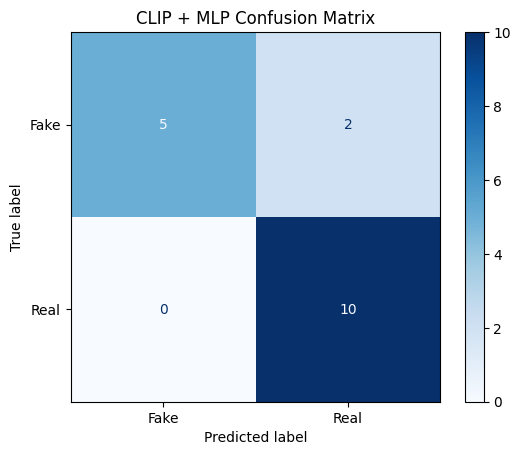

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("CLIP + MLP Confusion Matrix")
plt.show()


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
# Replace 'your_model_folder' with the actual name of the folder in your Drive
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "clip_mlp_model.pkl") # Using a name to reflect it's the CLIP+MLP model

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Ensure the trained model object exists
if 'clf' in locals():
    # Save the model
    joblib.dump(clf, model_path)

    print(f"✅ Model saved to: {model_path}")
else:
    print("❌ Trained model object 'clf' not found. Please ensure you have trained the model before saving.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/models/clip_mlp_model.pkl


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CLIP+MLP model loaded successfully from: /content/drive/MyDrive/models/clip_mlp_model.pkl

Predicting for sample with ID: de83cc
Text: this hydrated area of grass around my tree
The model predicts this image is: Real


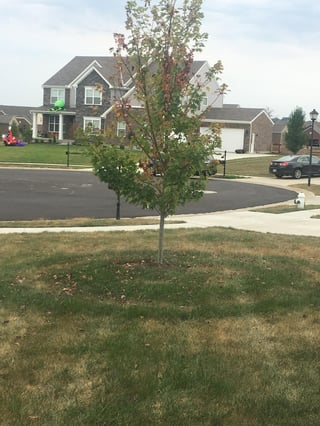

In [ ]:
import joblib
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd # Ensure pandas is imported

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the saved CLIP+MLP model
model_path = "/content/drive/MyDrive/models/clip_mlp_model.pkl" # Adjust if you saved it with a different name

# Check if the model file exists before attempting to load
loaded_model = None # Initialize to None
if os.path.exists(model_path):
    # Load the model
    loaded_model = joblib.load(model_path)
    print(f"✅ CLIP+MLP model loaded successfully from: {model_path}")
else:
    print(f"❌ Model file not found at: {model_path}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")


# --- Feature Extraction Function (Assuming CLIP model and preprocess are loaded) ---
# Ensure CLIP model and preprocess are loaded
if 'model' not in globals() or 'preprocess' not in globals() or 'device' not in globals():
    print("Loading CLIP model and preprocessor...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        # Load the CLIP model and preprocessor
        import clip # Ensure clip is imported
        model, preprocess = clip.load("ViT-B/32", device=device)
        print("✅ CLIP model and preprocessor loaded.")
    except Exception as e:
        print(f"❌ Error loading CLIP model: {e}")
        model = None
        preprocess = None


def extract_clip_features(image_path, text):
    """Extracts CLIP features for an image and text pair."""
    if model is None or preprocess is None:
        print("Error: CLIP model or preprocessor not loaded.")
        return None, None

    try:
        # Image features
        image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
        img_feat = image_features.cpu().numpy()[0]

        # Text features
        text_tokenized = clip.tokenize([str(text)]).to(device) # Ensure text is string
        with torch.no_grad():
            text_features = model.encode_text(text_tokenized)
        txt_feat = text_features.cpu().numpy()[0]

        return img_feat, txt_feat

    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        return None, None
    except Exception as e:
        print(f"Error extracting CLIP features for {image_path} and text '{text}': {e}")
        return None, None


def predict_single_sample(image_path, text, model):
    """Predicts the real/fake label for a single sample using the loaded model."""
    if model is None:
        print("Error: Model not loaded.")
        return None

    img_feat, text_feat = extract_clip_features(image_path, text)

    if img_feat is not None and text_feat is not None:
        # Combine features
        combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

        # Make prediction
        try:
            prediction = model.predict(combined_features)[0]
            # Map prediction to label (assuming 0 for Fake, 1 for Real as per training)
            prediction_label = "Fake" if prediction == 0 else "Real"
            return prediction_label
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return None
    else:
        print("Could not extract features for prediction.")
        return None


# --- Select a Sample and Predict ---
# Assuming df_sample is already loaded from previous cells (e.g., from sample_100.tsv)
# and filtered for existing image paths.
if 'df_sample' in locals() and not df_sample.empty:
    # Define the index of the sample you want to test
    sample_index = 39 # You can change this index to test a different sample

    if sample_index < len(df_sample):
        sample = df_sample.iloc[67]

        # Ensure necessary columns are present
        if 'image_path' in sample and 'clean_title' in sample and 'id' in sample:
            img_path = sample['image_path']
            sample_text = sample['clean_title']
            sample_id = sample['id']

            if os.path.exists(img_path):
                print(f"\nPredicting for sample with ID: {sample_id}")
                print(f"Text: {sample_text}")

                prediction_result = predict_single_sample(img_path, sample_text, loaded_model)

                if prediction_result:
                    print(f"The model predicts this image is: {prediction_result}")

                    # Optional: Display the image
                    try:
                        img = Image.open(img_path)
                        display(img)
                    except Exception as e:
                        print(f"Could not display image: {e}")
                else:
                    print("Prediction could not be made for this sample.")

            else:
                print(f"\nImage file not found for sample with ID: {sample_id} at path: {img_path}")
                print(f"Text: {sample_text}")
                print("This sample might have been filtered out because the image file was missing.")

        else:
            print(f"\n❌ Selected sample (at index {sample_index}) is missing 'image_path', 'clean_title', or 'id' information.")

    else:
        print(f"\n❌ sample_index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")

else:
    print("\n❌ df_sample DataFrame is not loaded or is empty. Please load and preprocess your sample data first.")

Mode3: TF-IDF (Text) + VGG16 (Image) + MLP

[Go to Cell 14I1elCDusbk](#scrollTo=14I1elCDusbk)

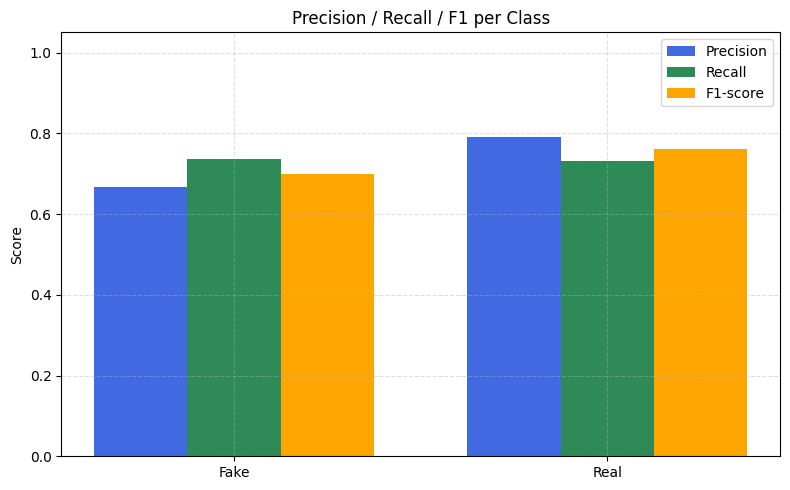

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Get metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])
classes = ['Fake', 'Real']

# Plotting
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision', color='royalblue')
plt.bar(x, recall, width, label='Recall', color='seagreen')
plt.bar(x + width, f1, width, label='F1-score', color='orange')

plt.xticks(x, classes)
plt.ylabel("Score")
plt.title("Precision / Recall / F1 per Class")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive where you want to save the model
model_dir = "/content/drive/MyDrive/models"
model_path = os.path.join(model_dir, "vgg_bert_mlp_model.pkl") # Using a name to reflect this model

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Ensure the trained model object exists
if 'clf_vgg_bert_mlp' in locals():
    # Save the model
    joblib.dump(clf_vgg_bert_mlp, model_path)

    print(f"✅ VGG16 + BERT + MLP model saved to: {model_path}")
else:
    print("❌ Trained model object 'clf_vgg_bert_mlp' not found. Please ensure you have trained this model before saving.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ VGG16 + BERT + MLP model saved to: /content/drive/MyDrive/models/vgg_bert_mlp_model.pkl


model_4

⚠️ Filtered DataFrame not found. Using original 'df' DataFrame with 224 rows. Image errors may occur.

Extracting image features using EfficientNet...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


✅ EfficientNet_B0 model loaded.
✅ EfficientNet_B0 image transform defined.

Extracting text features using DistilBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ DistilBERT model (distilbert-base-uncased) loaded.

Extracting and collecting features for valid samples...


Feature Extraction:  63%|██████▎   | 142/224 [00:58<00:30,  2.65it/s]

EfficientNet image feature extraction error for /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


Feature Extraction:  80%|████████  | 180/224 [01:08<00:11,  3.76it/s]

EfficientNet image feature extraction error for /content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/c50lt7l.jpg'


Feature Extraction: 100%|██████████| 224/224 [01:17<00:00,  2.89it/s]



Successfully extracted and collected features for 222 samples.
✅ Number of image and text features match and are not empty. Proceeding to training.

Data split into 177 training and 45 test samples.

Training MLP Classifier (MLP Tuning)...
✅ MLP Classifier training completed.

Evaluating the model...

--- Evaluation Results (DistilBERT + EfficientNet + MLP - Tuned) ---
✅ Accuracy: 88.89 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86        19
         1.0       0.86      0.96      0.91        26

    accuracy                           0.89        45
   macro avg       0.90      0.88      0.88        45
weighted avg       0.89      0.89      0.89        45



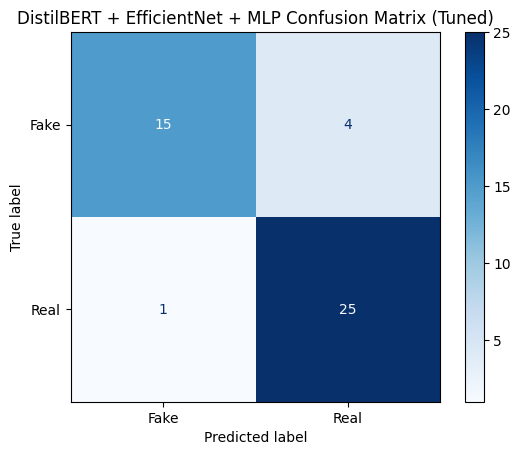

✅ Confusion matrix plotted.

Attempting to save the trained model...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.
✅ Model directory created or already exists at: /content/drive/MyDrive/models
✅ DistilBERT + EfficientNet + MLP model saved to: /content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl


In [ ]:
# Mode 7: DistilBERT (Text) + EfficientNet (Image) + MLP Fusion (Attempt 3: More Robust Feature Collection)

import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel # Using DistilBERT
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd # Ensure pandas is imported
import joblib # Import joblib for saving the model
from google.colab import drive # Import drive for mounting

# Ensure df_valid_for_resnet (or similar filtered DataFrame) is available
# Using df_valid_for_resnet assuming the previous check was successful and this DataFrame contains valid samples
if 'df_valid_for_resnet' in locals() and not df_valid_for_resnet.empty:
    print("✅ Using 'df_valid_for_resnet' DataFrame for training with", len(df_valid_for_resnet), "rows.")
    df_to_process = df_valid_for_resnet.copy() # Use a copy
elif 'df_filtered_valid_images' in locals() and not df_filtered_valid_images.empty:
     print("✅ 'df_valid_for_resnet' not found or empty. Using 'df_filtered_valid_images' DataFrame with", len(df_filtered_valid_images), "rows.")
     df_to_process = df_filtered_valid_images.copy()
elif 'df' in locals() and not df.empty:
    print("⚠️ Filtered DataFrame not found. Using original 'df' DataFrame with", len(df), "rows. Image errors may occur.")
    df_to_process = df.copy()
else:
    print("Error: No valid DataFrame loaded. Please load and preprocess your data first.")
    df_to_process = pd.DataFrame() # Create an empty DataFrame


if not df_to_process.empty:
    # --- Image Feature Extraction (EfficientNet) ---
    print("\nExtracting image features using EfficientNet...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained EfficientNet (e.g., EfficientNet_B0)
    # Use weights parameter as pretrained is deprecated
    efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    # Remove the final classification layer to get features
    efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
    efficientnet.eval().to(device)
    print("✅ EfficientNet_B0 model loaded.")

    # Define image transform for EfficientNet
    # Use weights parameter as pretrained is deprecated
    preprocess_efficientnet = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
    print("✅ EfficientNet_B0 image transform defined.")

    def extract_efficientnet_features(path):
        try:
            img = Image.open(path).convert("RGB")
            img = preprocess_efficientnet(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = efficientnet(img).squeeze() # Squeeze to remove spatial dimensions
            return feat.cpu().numpy()
        except Exception as e:
            # Print error but return None to indicate failure
            print(f"EfficientNet image feature extraction error for {path}: {e}")
            return None # Return None on error

    # --- Text Feature Extraction (DistilBERT) ---
    print("\nExtracting text features using DistilBERT...")
    # Using a base DistilBERT model
    distilbert_model_name = "distilbert-base-uncased"
    tokenizer_distilbert = DistilBertTokenizer.from_pretrained(distilbert_model_name)
    model_distilbert = DistilBertModel.from_pretrained(distilbert_model_name)
    model_distilbert.to(device).eval()
    print(f"✅ DistilBERT model ({distilbert_model_name}) loaded.")

    def extract_distilbert_features(text):
        try:
            tokens = tokenizer_distilbert(str(text), return_tensors='pt', padding=True, truncation=True, max_length=64) # Ensure text is string
            tokens = {k: v.to(device) for k, v in tokens.items()}
            with torch.no_grad():
                outputs = model_distilbert(**tokens)
            # Using the representation of the first token (often [CLS]) from the last hidden state
            feat = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
            return feat
        except Exception as e:
            print(f"DistilBERT text feature extraction error for '{str(text)[:50]}...': {e}") # Ensure text is string for slicing
            return None # Return None on error


    # Collect features and labels ONLY for samples where BOTH extractions are successful
    image_features_efficientnet = []
    text_features_distilbert = []
    labels = []

    print("\nExtracting and collecting features for valid samples...")
    for i, row in tqdm(df_to_process.iterrows(), total=len(df_to_process), desc="Feature Extraction"):
        img_feat = extract_efficientnet_features(row.get('image_path')) # Use .get() for safety
        text_feat = extract_distilbert_features(row.get('clean_title')) # Use .get() for safety

        # Only collect features and label if BOTH image and text feature extraction were successful AND label is not None
        if img_feat is not None and text_feat is not None and pd.notna(row.get('2_way_label')):
             image_features_efficientnet.append(img_feat)
             text_features_distilbert.append(text_feat)
             labels.append(row['2_way_label']) # Append the actual label if valid
        else:
             # Optionally print which sample was skipped and why
             pass # Skip samples where feature extraction failed or label is missing


    print(f"\nSuccessfully extracted and collected features for {len(image_features_efficientnet)} samples.")

    # Ensure the number of image and text features match and are not empty for training
    if len(image_features_efficientnet) == len(text_features_distilbert) and len(image_features_efficientnet) > 0:
        print("✅ Number of image and text features match and are not empty. Proceeding to training.")

        # --- Combine Features and Prepare Data ---
        X = np.hstack([np.array(image_features_efficientnet), np.array(text_features_distilbert)])
        y = np.array(labels) # Use the collected labels

        # --- Train-Test Split ---
        # Use stratify to maintain class distribution
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        print(f"\nData split into {len(X_train)} training and {len(X_test)} test samples.")

        # --- Train MLP Classifier (MLP Tuning) ---
        print("\nTraining MLP Classifier (MLP Tuning)...")
        # Using a complex MLP architecture with increased max_iter
        clf_distilbert_efficientnet_mlp = MLPClassifier(hidden_layer_sizes=(1024, 512, 256, 128), max_iter=800, random_state=42, early_stopping=True, solver='adam', activation='relu') # More layers, increased max_iter
        clf_distilbert_efficientnet_mlp.fit(X_train, y_train)
        print("✅ MLP Classifier training completed.")

        # --- Evaluate Model ---
        print("\nEvaluating the model...")
        y_pred = clf_distilbert_efficientnet_mlp.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print("\n--- Evaluation Results (DistilBERT + EfficientNet + MLP - Tuned) ---")
        print("✅ Accuracy:", round(acc * 100, 2), "%")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # --- Optional: Confusion Matrix Plot ---
        try:
            import matplotlib.pyplot as plt
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
            disp.plot(cmap=plt.cm.Blues)
            plt.title("DistilBERT + EfficientNet + MLP Confusion Matrix (Tuned)")
            plt.show()
            print("✅ Confusion matrix plotted.")
        except Exception as e:
            print(f"❌ Could not plot confusion matrix: {e}")

        # --- Save the Trained Model ---
        print("\nAttempting to save the trained model...")
        # Mount Google Drive (if not already mounted)
        try:
             drive.mount('/content/drive')
             print("✅ Google Drive mounted.")
        except Exception as e:
             print(f"❌ Failed to mount Google Drive: {e}")
             print("Skipping model save.")
             clf_distilbert_efficientnet_mlp = None # Ensure model object is None if drive fails to mount


        if 'clf_distilbert_efficientnet_mlp' in locals() and clf_distilbert_efficientnet_mlp is not None:
            # Define the path to the folder in your Google Drive where you want to save the model
            model_dir = "/content/drive/MyDrive/models"
            model_path = os.path.join(model_dir, "distilbert_efficientnet_mlp_model.pkl") # Naming the file

            # Create the directory if it doesn't exist
            try:
                os.makedirs(model_dir, exist_ok=True)
                print(f"✅ Model directory created or already exists at: {model_dir}")
            except Exception as e:
                 print(f"❌ Failed to create model directory: {e}")
                 print("Skipping model save.")
                 model_path = None # Set path to None to skip save


            if model_path:
                 # Save the model
                 try:
                     joblib.dump(clf_distilbert_efficientnet_mlp, model_path)
                     print(f"✅ DistilBERT + EfficientNet + MLP model saved to: {model_path}")
                 except Exception as e:
                     print(f"❌ Failed to save the model to {model_path}: {e}")

        else:
            print("❌ Trained model object 'clf_distilbert_efficientnet_mlp' not found or Drive not mounted. Model could not be saved.")


    else:
        print("\n❌ Error: Number of image and text features do not match or are empty after collection. Cannot combine features and train model.")
        print(f"EfficientNet features count: {len(image_features_efficientnet)}, DistilBERT features count: {len(text_features_distilbert)}")
else:
    print("\n❌ Cannot proceed with feature extraction and training because the DataFrame to process is empty.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.

Predicting for sample with ID: 34unnd
Text: oc canoe off the coast of washington state
The DistilBERT + EfficientNet + MLP model predicts this image is: Real


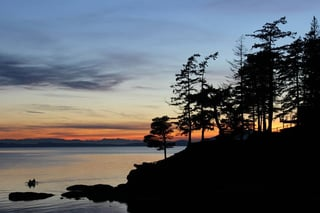

In [ ]:
import joblib
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from google.colab import drive
from transformers import DistilBertTokenizer, DistilBertModel # Import DistilBERT components


# --- Load the saved DistilBERT + EfficientNet + MLP model ---
# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("✅ Google Drive mounted.")
except Exception as e:
    print(f"❌ Failed to mount Google Drive: {e}")
    print("Cannot load the model without Google Drive access.")
    loaded_model_distilbert_efficientnet_mlp = None # Set model to None if drive fails


if 'loaded_model_distilbert_efficientnet_mlp' not in locals() or loaded_model_distilbert_efficientnet_mlp is None:
    # Define the path to the saved DistilBERT + EfficientNet + MLP model
    model_path_distilbert_efficientnet_mlp = "/content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl" # Adjust if you saved it with a different name

    # Check if the model file exists before attempting to load
    if os.path.exists(model_path_distilbert_efficientnet_mlp):
        try:
            # Load the model
            loaded_model_distilbert_efficientnet_mlp = joblib.load(model_path_distilbert_efficientnet_mlp)
            print(f"✅ DistilBERT + EfficientNet + MLP model loaded successfully from: {model_path_distilbert_efficientnet_mlp}")
        except Exception as e:
            print(f"❌ Error loading model from {model_path_distilbert_efficientnet_mlp}: {e}")
            loaded_model_distilbert_efficientnet_mlp = None
    else:
        print(f"❌ Model file not found at: {model_path_distilbert_efficientnet_mlp}")
        print("Please ensure the path is correct and the file exists in your Google Drive.")
        loaded_model_distilbert_efficientnet_mlp = None # Ensure it's None if not found


# --- Load Feature Extractors (EfficientNet and DistilBERT) ---
# Ensure EfficientNet and DistilBERT models and preprocessors/tokenizers are loaded
# Check if they are already in the global scope from the training cell
if 'efficientnet' not in globals() or 'preprocess_efficientnet' not in globals():
    print("Loading EfficientNet model and preprocessor...")
    try:
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        efficientnet.eval().to(device)
        preprocess_efficientnet = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
        print("✅ EfficientNet_B0 model and preprocessor loaded.")
    except Exception as e:
        print(f"❌ Error loading EfficientNet: {e}")
        efficientnet = None
        preprocess_efficientnet = None

if 'tokenizer_distilbert' not in globals() or 'model_distilbert' not in globals():
    print("Loading DistilBERT model and tokenizer...")
    try:
        distilbert_model_name = "distilbert-base-uncased"
        tokenizer_distilbert = DistilBertTokenizer.from_pretrained(distilbert_model_name)
        model_distilbert = DistilBertModel.from_pretrained(distilbert_model_name)
        model_distilbert.to(device).eval()
        print(f"✅ DistilBERT model ({distilbert_model_name}) and tokenizer loaded.")
    except Exception as e:
        print(f"❌ Error loading DistilBERT: {e}")
        tokenizer_distilbert = None
        model_distilbert = None


# --- Define Feature Extraction Function ---
def extract_distilbert_efficientnet_features(image_path, text):
    """Extracts EfficientNet image features and DistilBERT text features."""
    img_feat = None
    text_feat = None

    if efficientnet is None or preprocess_efficientnet is None:
        print("Error: EfficientNet model or preprocessor not loaded.")
        return None, None

    if tokenizer_distilbert is None or model_distilbert is None:
        print("Error: DistilBERT model or tokenizer not loaded.")
        return None, None

    try:
        # Image features (EfficientNet)
        img = Image.open(image_path).convert("RGB")
        img = preprocess_efficientnet(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = efficientnet(img).squeeze()
        img_feat = img_feat.cpu().numpy()
    except FileNotFoundError:
        print(f"Image file not found for EfficientNet: {image_path}")
        img_feat = None # Explicitly set to None on error
    except Exception as e:
        print(f"Error extracting EfficientNet features for {image_path}: {e}")
        img_feat = None # Explicitly set to None on error


    try:
        # Text features (DistilBERT)
        tokens = tokenizer_distilbert(str(text), return_tensors='pt', padding=True, truncation=True, max_length=64)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model_distilbert(**tokens)
        text_feat = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
    except Exception as e:
        print(f"Error extracting DistilBERT features for text '{str(text)[:50]}...': {e}")
        text_feat = None # Explicitly set to None on error

    return img_feat, text_feat


# --- Define Prediction Function ---
def predict_single_sample_distilbert_efficientnet(image_path, text, model):
    """Predicts the real/fake label for a single sample using the loaded DistilBERT+EfficientNet+MLP model."""
    if model is None:
        print("Error: Model not loaded.")
        return None

    img_feat, text_feat = extract_distilbert_efficientnet_features(image_path, text)

    if img_feat is not None and text_feat is not None:
        # Combine features
        combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

        # Make prediction
        try:
            prediction = model.predict(combined_features)[0]
            # Map prediction to label (assuming 0 for Fake, 1 for Real as per training)
            prediction_label = "Fake" if prediction == 0 else "Real"
            return prediction_label
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return None
    else:
        print("Could not extract features for prediction.")
        return None


# --- Select a Sample and Predict ---
# Assuming df_sample is already loaded from previous cells (e.g., from sample_100.tsv)
# and filtered for existing image paths.
if 'df_sample' in locals() and not df_sample.empty:
    # Define the index of the sample you want to test
    sample_index = 39 # You can change this index to test a different sample

    if sample_index < len(df_sample):
        sample = df_sample.iloc[sample_index] # Use the selected index

        # Ensure necessary columns are present
        if 'image_path' in sample and 'clean_title' in sample and 'id' in sample:
            img_path = sample['image_path']
            sample_text = sample['clean_title']
            sample_id = sample['id']

            # Ensure the image file exists
            if os.path.exists(img_path):
                print(f"\nPredicting for sample with ID: {sample_id}")
                print(f"Text: {sample_text}")

                # Use the loaded DistilBERT + EfficientNet + MLP model for prediction
                if loaded_model_distilbert_efficientnet_mlp is not None:
                    prediction_result = predict_single_sample_distilbert_efficientnet(img_path, sample_text, loaded_model_distilbert_efficientnet_mlp)

                    if prediction_result:
                        print(f"The DistilBERT + EfficientNet + MLP model predicts this image is: {prediction_result}")

                        # Optional: Display the image
                        try:
                            img = Image.open(img_path)
                            display(img)
                        except Exception as e:
                            print(f"Could not display image: {e}")
                    else:
                        print("Prediction could not be made for this sample.")
                else:
                    print("Model not loaded. Cannot make prediction.")

            else:
                print(f"\nImage file not found for sample with ID: {sample_id} at path: {img_path}")
                print(f"Text: {sample_text}")
                print("This sample might have been filtered out because the image file was missing.")

        else:
            print(f"\n❌ Selected sample (at index {sample_index}) is missing 'image_path', 'clean_title', or 'id' information.")

    else:
        print(f"\n❌ sample_index {sample_index} is out of bounds for df_sample (size: {len(df_sample)}). Please choose an index between 0 and {len(df_sample)-1}.")

else:
    print("\n❌ df_sample DataFrame is not loaded or is empty. Please load and preprocess your sample data first by running the cell that loads 'sample_100.tsv'.")

[Go to the cell that loads sample_100.tsv](#scrollTo=f953be9f)

Using device: cpu
✅ DistilBERT + EfficientNet + MLP model loaded successfully from: /content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl
Please upload an image file:


Saving view-from-my-bathroom-window-in-florence-italy-v0-y4gs5wcr9iff1.webp to view-from-my-bathroom-window-in-florence-italy-v0-y4gs5wcr9iff1.webp
Uploaded file: view-from-my-bathroom-window-in-florence-italy-v0-y4gs5wcr9iff1.webp

Uploaded Image:


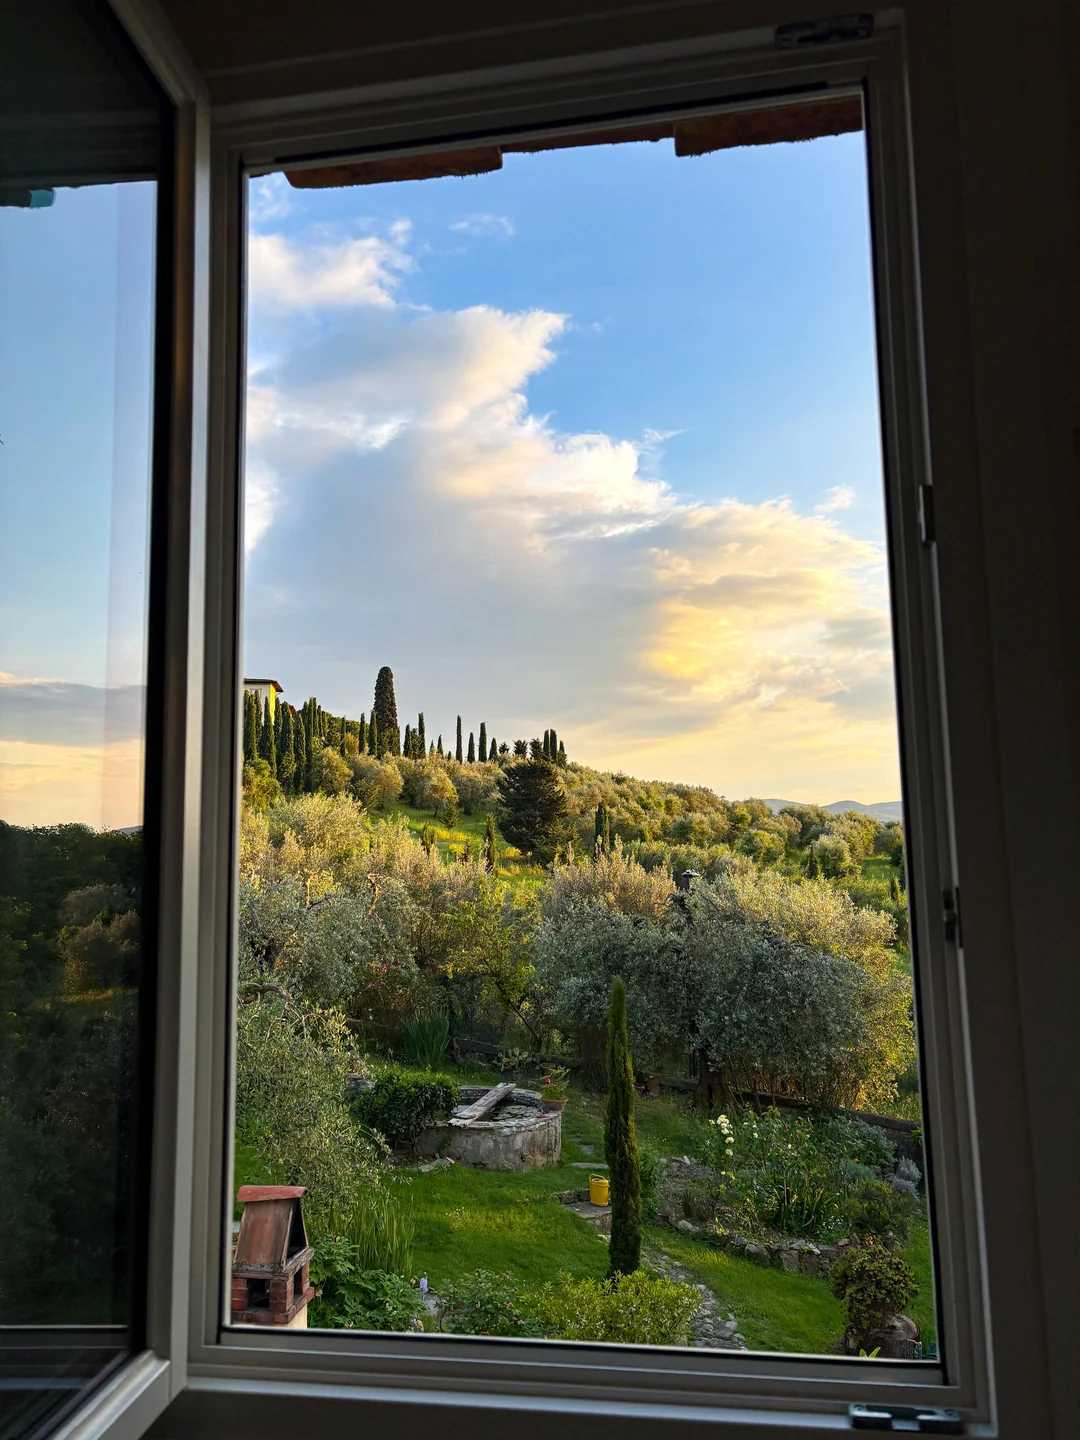


Making prediction...

--- Prediction Result for 'view-from-my-bathroom-window-in-florence-italy-v0-y4gs5wcr9iff1.webp' ---
The model predicts this image is: Real
---------------------------------------------

Cleaned up temporary file: /content/view-from-my-bathroom-window-in-florence-italy-v0-y4gs5wcr9iff1.webp


In [ ]:
from google.colab import files
import os
from PIL import Image
from IPython.display import display
import numpy as np
import joblib
import torch
from torchvision import models, transforms
from transformers import DistilBertTokenizer, DistilBertModel # Import DistilBERT components
# import ipywidgets as widgets # Not needed for simple upload and predict
# from IPython.display import display as display_ipython # Not needed for simple upload and predict

# Define the device to use for computations (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# --- Load the saved DistilBERT + EfficientNet + MLP model ---
# Assuming Google Drive is mounted from previous cells and the model exists.
# If not, you might need to run the cell that mounts Google Drive and loads the model first.
model_path_distilbert_efficientnet_mlp = "/content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl" # Adjust if you saved it with a different name

loaded_model_distilbert_efficientnet_mlp = None # Initialize to None
if os.path.exists(model_path_distilbert_efficientnet_mlp):
    try:
        # Load the model
        loaded_model_distilbert_efficientnet_mlp = joblib.load(model_path_distilbert_efficientnet_mlp)
        print(f"✅ DistilBERT + EfficientNet + MLP model loaded successfully from: {model_path_distilbert_efficientnet_mlp}")
    except Exception as e:
        print(f"❌ Error loading model from {model_path_distilbert_efficientnet_mlp}: {e}")
        loaded_model_distilbert_efficientnet_mlp = None
else:
    print(f"❌ Model file not found at: {model_path_distilbert_efficientnet_mlp}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")
    loaded_model_distilbert_efficientnet_mlp = None # Ensure it's None if not found


# --- Load Feature Extractors (EfficientNet and DistilBERT) ---
# Ensure EfficientNet and DistilBERT models and preprocessors/tokenizers are loaded
# Check if they are already in the global scope from the training cell
if 'efficientnet' not in globals() or 'preprocess_efficientnet' not in globals():
    print("Loading EfficientNet model and preprocessor...")
    try:
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        efficientnet.eval().to(device)
        preprocess_efficientnet = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
        print("✅ EfficientNet_B0 model and preprocessor loaded.")
    except Exception as e:
        print(f"❌ Error loading EfficientNet: {e}")
        efficientnet = None
        preprocess_efficientnet = None

if 'tokenizer_distilbert' not in globals() or 'model_distilbert' not in globals():
    print("Loading DistilBERT model and tokenizer...")
    try:
        distilbert_model_name = "distilbert-base-uncased"
        tokenizer_distilbert = DistilBertTokenizer.from_pretrained(distilbert_model_name)
        model_distilbert = DistilBertModel.from_pretrained(distilbert_model_name)
        model_distilbert.to(device).eval()
        print(f"✅ DistilBERT model ({distilbert_model_name}) and tokenizer loaded.")
    except Exception as e:
        print(f"❌ Error loading DistilBERT: {e}")
        tokenizer_distilbert = None
        model_distilbert = None


# --- Define Feature Extraction Function (Same as before) ---
def extract_distilbert_efficientnet_features(image_path, text):
    """Extracts EfficientNet image features and DistilBERT text features."""
    img_feat = None
    text_feat = None

    if efficientnet is None or preprocess_efficientnet is None:
        print("Error: EfficientNet model or preprocessor not loaded.")
        return None, None

    if tokenizer_distilbert is None or model_distilbert is None:
        print("Error: DistilBERT model or tokenizer not loaded.")
        return None, None


    try:
        # Image features (EfficientNet)
        img = Image.open(image_path).convert("RGB")
        img = preprocess_efficientnet(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = efficientnet(img).squeeze()
        img_feat = img_feat.cpu().numpy()
    except FileNotFoundError:
        print(f"Image file not found for EfficientNet: {image_path}")
        img_feat = None # Explicitly set to None on error
    except Exception as e:
        print(f"Error extracting EfficientNet features for {image_path}: {e}")
        img_feat = None # Explicitly set to None on error


    try:
        # Text features (DistilBERT)
        tokens = tokenizer_distilbert(str(text), return_tensors='pt', padding=True, truncation=True, max_length=64)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model_distilbert(**tokens)
        text_feat = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
    except Exception as e:
        print(f"Error extracting DistilBERT features for text '{str(text)[:50]}...': {e}")
        text_feat = None # Explicitly set to None on error

    return img_feat, text_feat

# --- Define Prediction Function (Same as before) ---
def predict_single_sample_distilbert_efficientnet(image_path, text, model):
    """Predicts the real/fake label for a single sample using the loaded DistilBERT+EfficientNet+MLP model."""
    if model is None:
        print("Error: Model not loaded.")
        return None

    img_feat, text_feat = extract_distilbert_efficientnet_features(image_path, text)

    if img_feat is not None and text_feat is not None:
        # Combine features
        combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

        # Make prediction
        try:
            prediction = model.predict(combined_features)[0]
            # Map prediction to label (assuming 0 for Fake, 1 for Real as per training)
            prediction_label = "Fake" if prediction == 0 else "Real"
            return prediction_label
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return None
    else:
        print("Could not extract features for prediction.")
        return None

# --- File Upload and Prediction ---
print("Please upload an image file:")
uploaded = files.upload()

if uploaded:
    for filename in uploaded.keys():
        print(f'Uploaded file: {filename}')

        # Save the uploaded file temporarily
        temp_image_path = f'/content/{filename}'
        with open(temp_image_path, 'wb') as f:
            f.write(uploaded[filename])

        # Display the uploaded image
        try:
            img = Image.open(temp_image_path)
            print("\nUploaded Image:")
            display(img) # Use standard display
        except Exception as e:
            print(f"Could not display uploaded image: {e}")

        # Use a placeholder text for prediction since no text input is provided
        placeholder_text = "" # You can change this to a different placeholder if needed

        # Make prediction using the loaded model and the placeholder text
        if loaded_model_distilbert_efficientnet_mlp is not None:
            print("\nMaking prediction...")
            prediction_result = predict_single_sample_distilbert_efficientnet(temp_image_path, placeholder_text, loaded_model_distilbert_efficientnet_mlp)

            if prediction_result:
                print(f"\n--- Prediction Result for '{filename}' ---") # Added clear heading
                print(f"The model predicts this image is: {prediction_result}")
                print(f"---------------------------------------------") # Added separator


            else:
                print("\nCould not make a prediction for the uploaded image.")

            # Clean up the temporary file
            os.remove(temp_image_path)
            print(f"\nCleaned up temporary file: {temp_image_path}")

        else:
            print("\nModel is not loaded. Cannot make prediction.")

else:
    print("No file was uploaded.")

Using device: cpu
✅ DistilBERT + EfficientNet + MLP model loaded successfully from: /content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl
Please upload an image file:


Saving my-daughter-made-some-restaurant-menus-last-night-v0-zop62qhrggff1.webp to my-daughter-made-some-restaurant-menus-last-night-v0-zop62qhrggff1.webp
Uploaded file: my-daughter-made-some-restaurant-menus-last-night-v0-zop62qhrggff1.webp

Uploaded Image:


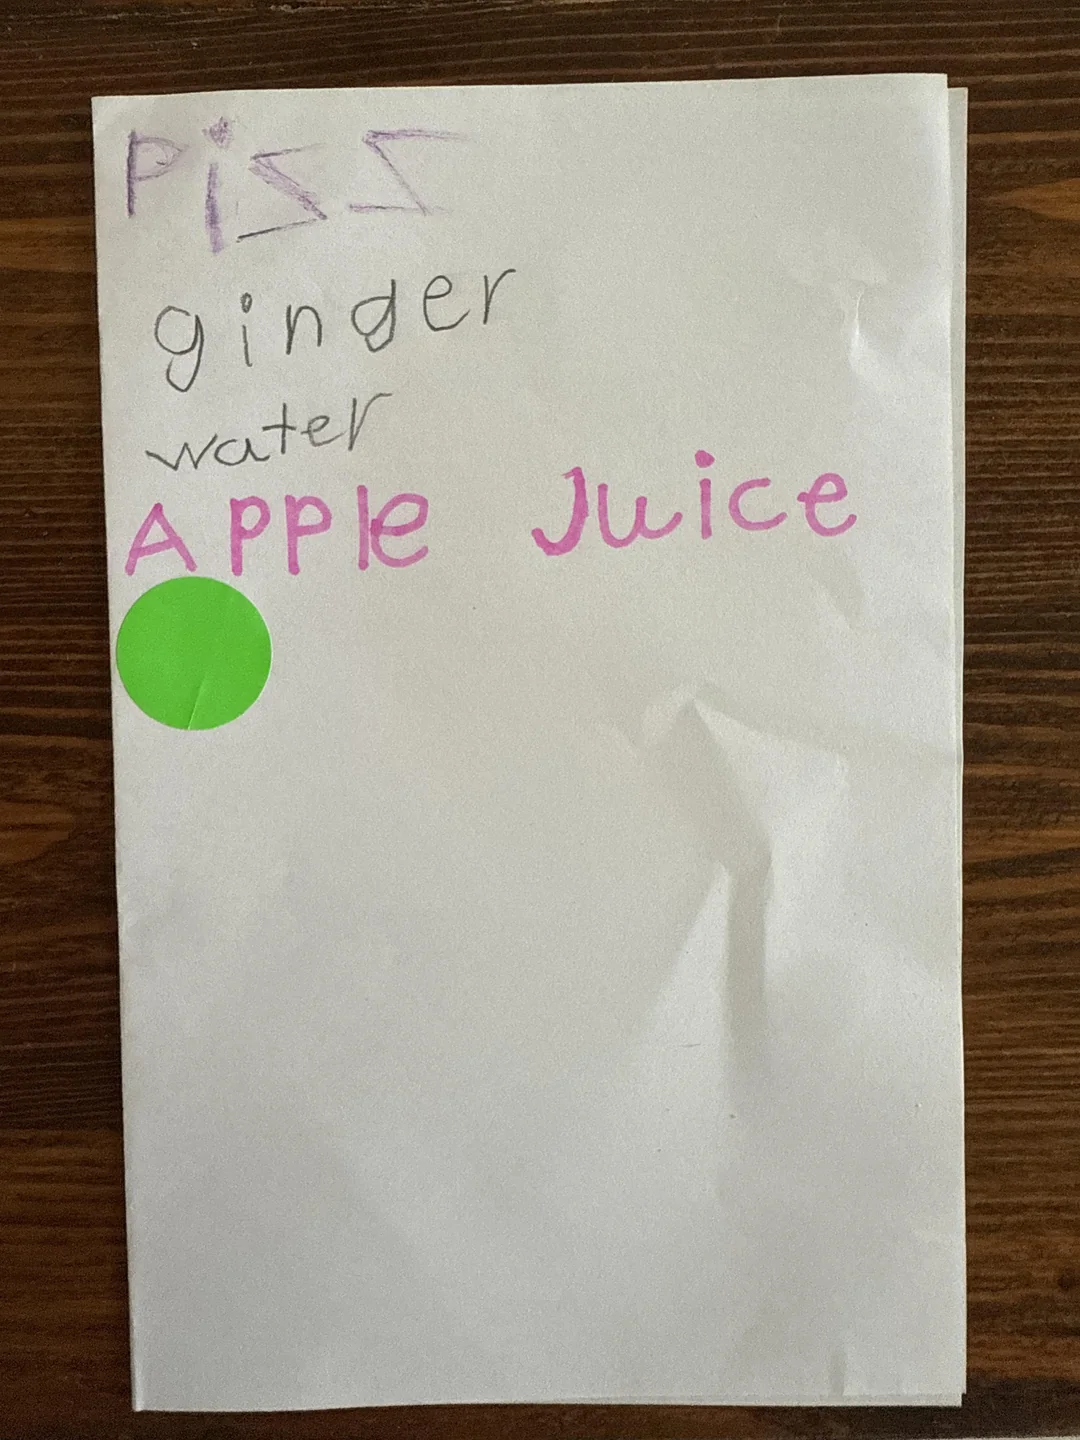


Making prediction...

*** PREDICTION RESULT for 'my-daughter-made-some-restaurant-menus-last-night-v0-zop62qhrggff1.webp' ***
The model predicts this image is: >>> Fake <<<

Cleaned up temporary file: /content/my-daughter-made-some-restaurant-menus-last-night-v0-zop62qhrggff1.webp


In [ ]:
from google.colab import files
import os
from PIL import Image
from IPython.display import display
import numpy as np
import joblib
import torch
from torchvision import models, transforms
from transformers import DistilBertTokenizer, DistilBertModel # Import DistilBERT components
# import ipywidgets as widgets # Not needed for simple upload and predict
# from IPython.display import display as display_ipython # Not needed for simple upload and predict

# Define the device to use for computations (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# --- Load the saved DistilBERT + EfficientNet + MLP model ---
# Assuming Google Drive is mounted from previous cells and the model exists.
# If not, you might need to run the cell that mounts Google Drive and loads the model first.
model_path_distilbert_efficientnet_mlp = "/content/drive/MyDrive/models/distilbert_efficientnet_mlp_model.pkl" # Adjust if you saved it with a different name

loaded_model_distilbert_efficientnet_mlp = None # Initialize to None
if os.path.exists(model_path_distilbert_efficientnet_mlp):
    try:
        # Load the model
        loaded_model_distilbert_efficientnet_mlp = joblib.load(model_path_distilbert_efficientnet_mlp)
        print(f"✅ DistilBERT + EfficientNet + MLP model loaded successfully from: {model_path_distilbert_efficientnet_mlp}")
    except Exception as e:
        print(f"❌ Error loading model from {model_path_distilbert_efficientnet_mlp}: {e}")
        loaded_model_distilbert_efficientnet_mlp = None
else:
    print(f"❌ Model file not found at: {model_path_distilbert_efficientnet_mlp}")
    print("Please ensure the path is correct and the file exists in your Google Drive.")
    loaded_model_distilbert_efficientnet_mlp = None # Ensure it's None if not found


# --- Load Feature Extractors (EfficientNet and DistilBERT) ---
# Ensure EfficientNet and DistilBERT models and preprocessors/tokenizers are loaded
# Check if they are already in the global scope from the training cell
if 'efficientnet' not in globals() or 'preprocess_efficientnet' not in globals():
    print("Loading EfficientNet model and preprocessor...")
    try:
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        efficientnet = torch.nn.Sequential(*(list(efficientnet.children())[:-1]))
        efficientnet.eval().to(device)
        preprocess_efficientnet = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
        print("✅ EfficientNet_B0 model and preprocessor loaded.")
    except Exception as e:
        print(f"❌ Error loading EfficientNet: {e}")
        efficientnet = None
        preprocess_efficientnet = None

if 'tokenizer_distilbert' not in globals() or 'model_distilbert' not in globals():
    print("Loading DistilBERT model and tokenizer...")
    try:
        distilbert_model_name = "distilbert-base-uncased"
        tokenizer_distilbert = DistilBertTokenizer.from_pretrained(distilbert_model_name)
        model_distilbert = DistilBertModel.from_pretrained(distilbert_model_name)
        model_distilbert.to(device).eval()
        print(f"✅ DistilBERT model ({distilbert_model_name}) and tokenizer loaded.")
    except Exception as e:
        print(f"❌ Error loading DistilBERT: {e}")
        tokenizer_distilbert = None
        model_distilbert = None


# --- Define Feature Extraction Function (Same as before) ---
def extract_distilbert_efficientnet_features(image_path, text):
    """Extracts EfficientNet image features and DistilBERT text features."""
    img_feat = None
    text_feat = None

    if efficientnet is None or preprocess_efficientnet is None:
        print("Error: EfficientNet model or preprocessor not loaded.")
        return None, None

    if tokenizer_distilbert is None or model_distilbert is None:
        print("Error: DistilBERT model or tokenizer not loaded.")
        return None, None


    try:
        # Image features (EfficientNet)
        img = Image.open(image_path).convert("RGB")
        img = preprocess_efficientnet(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = efficientnet(img).squeeze()
        img_feat = img_feat.cpu().numpy()
    except FileNotFoundError:
        print(f"Image file not found for EfficientNet: {image_path}")
        img_feat = None # Explicitly set to None on error
    except Exception as e:
        print(f"Error extracting EfficientNet features for {image_path}: {e}")
        img_feat = None # Explicitly set to None on error


    try:
        # Text features (DistilBERT)
        tokens = tokenizer_distilbert(str(text), return_tensors='pt', padding=True, truncation=True, max_length=64)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model_distilbert(**tokens)
        text_feat = outputs.last_hidden_state[:, 0, :].cpu().numpy()[0]
    except Exception as e:
        print(f"Error extracting DistilBERT features for text '{str(text)[:50]}...': {e}")
        text_feat = None # Explicitly set to None on error

    return img_feat, text_feat

# --- Define Prediction Function (Same as before) ---
def predict_single_sample_distilbert_efficientnet(image_path, text, model):
    """Predicts the real/fake label for a single sample using the loaded DistilBERT+EfficientNet+MLP model."""
    if model is None:
        print("Error: Model not loaded.")
        return None

    img_feat, text_feat = extract_distilbert_efficientnet_features(image_path, text)

    if img_feat is not None and text_feat is not None:
        # Combine features
        combined_features = np.hstack([img_feat, text_feat]).reshape(1, -1)

        # Make prediction
        try:
            prediction = model.predict(combined_features)[0]
            # Map prediction to label (assuming 0 for Fake, 1 for Real as per training)
            prediction_label = "Fake" if prediction == 0 else "Real"
            return prediction_label
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return None
    else:
        print("Could not extract features for prediction.")
        return None

# --- File Upload and Prediction ---
print("Please upload an image file:")
uploaded = files.upload()

if uploaded:
    for filename in uploaded.keys():
        print(f'Uploaded file: {filename}')

        # Save the uploaded file temporarily
        temp_image_path = f'/content/{filename}'
        with open(temp_image_path, 'wb') as f:
            f.write(uploaded[filename])

        # Display the uploaded image
        try:
            img = Image.open(temp_image_path)
            print("\nUploaded Image:")
            display(img) # Use standard display
        except Exception as e:
            print(f"Could not display uploaded image: {e}")

        # Use a placeholder text for prediction since no text input is provided
        placeholder_text = "" # You can change this to a different placeholder if needed

        # Make prediction using the loaded model and the placeholder text
        if loaded_model_distilbert_efficientnet_mlp is not None:
            print("\nMaking prediction...")
            prediction_result = predict_single_sample_distilbert_efficientnet(temp_image_path, placeholder_text, loaded_model_distilbert_efficientnet_mlp)

            print("\n" + "="*30) # Add a separator line
            if prediction_result:
                print(f"*** PREDICTION RESULT for '{filename}' ***") # Make heading more prominent
                print(f"The model predicts this image is: >>> {prediction_result} <<<") # Highlight the result
            else:
                print(f"*** COULD NOT MAKE PREDICTION for '{filename}' ***") # Prominent error message
                print("Reason: Could not extract features or an error occurred during prediction.")
            print("="*30) # Add a separator line


            # Clean up the temporary file
            os.remove(temp_image_path)
            print(f"\nCleaned up temporary file: {temp_image_path}")

        else:
            print("\nModel is not loaded. Cannot make prediction.")

else:
    print("No file was uploaded.")

Generating Confusion Matrix for Retrained Oversampled Model...


<Figure size 600x600 with 0 Axes>

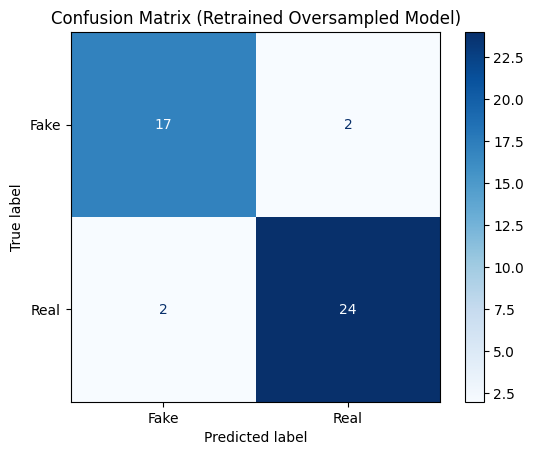

✅ Confusion matrix generated.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure clf_retrained_oversample, X_test, and y_test are available from previous cells

if 'clf_retrained_oversample' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("Generating Confusion Matrix for Retrained Oversampled Model...")

    # Make predictions on the original test set using the retrained oversampled model
    y_pred_retrained_oversample = clf_retrained_oversample.predict(X_test)

    # Compute the confusion matrix
    cm_retrained_oversample = confusion_matrix(y_test, y_pred_retrained_oversample)

    # Display the confusion matrix
    disp_retrained_oversample = ConfusionMatrixDisplay(confusion_matrix=cm_retrained_oversample, display_labels=['Fake', 'Real'])

    plt.figure(figsize=(6, 6))
    disp_retrained_oversample.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Retrained Oversampled Model)")
    plt.grid(False)
    plt.show()

    print("✅ Confusion matrix generated.")

else:
    print("Error: Necessary variables (clf_retrained_oversample, X_test, or y_test) are not available. Please run the retraining and evaluation cell (cell 0703d0b3) first.")

Click [here](#scrollTo=PD_5i3k1_0xp) to go to cell PD_5i3k1_0xp.

In [ ]:
import os

# Assuming df_sample is loaded and contains the 'image_path' column
if 'df_sample' in locals() and not df_sample.empty:
    image_path_to_find = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/6tlk99.jpg"

    # Find the row(s) where the 'image_path' column matches the specified path
    matching_rows = df_sample[df_sample['image_path'] == image_path_to_find]

    if not matching_rows.empty:
        # Get the index of the first matching row (iloc)
        iloc_index = matching_rows.index[0]

        print(f"The iloc index for image path '{image_path_to_find}' is: {iloc_index}")

        # Optional: Display the row to confirm
        print("\nDetails of the row:")
        display(df_sample.iloc[[iloc_index]])

    else:
        print(f"Image path '{image_path_to_find}' not found in the 'image_path' column of df_sample.")
else:
    print("Error: df_sample DataFrame is not loaded or is empty. Please load your sample data first.")

The iloc index for image path '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/6tlk99.jpg' is: 101

Details of the row:


author                                        clean_title  \
101  concernedindianguy  charlottesville photo man shouting angrily at ...   

      created_utc             domain  hasImage      id  \
101  1.502707e+09  independent.co.uk      True  6tlk99   

                                             image_url linked_submission_id  \
101  https://external-preview.redd.it/niGpzsZHQjevb...                  NaN   

     num_comments    score    subreddit  \
101        7618.0  36183.0  nottheonion   

                                                 title  upvote_ratio  \
101  Charlottesville photo: Man shouting angrily at...          0.76   

     2_way_label  3_way_label  6_way_label  \
101          1.0          0.0          0.0   

                                            image_path  
101  /content/drive/MyDrive/Colab Notebooks/Fakeddi...

In [ ]:
import os

# Assuming df_sample is loaded and contains the 'image_path' column
if 'df_sample' in locals() and not df_sample.empty:
    image_path_to_find = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/3jcpgv.jpg" # Updated image path

    # Find the row(s) where the 'image_path' column matches the specified path
    matching_rows = df_sample[df_sample['image_path'] == image_path_to_find]

    if not matching_rows.empty:
        # Get the index of the first matching row (iloc)
        iloc_index = matching_rows.index[0]

        print(f"The iloc index for image path '{image_path_to_find}' is: {iloc_index}")

        # Optional: Display the row to confirm
        print("\nDetails of the row:")
        display(df_sample.iloc[[iloc_index]])

    else:
        print(f"Image path '{image_path_to_find}' not found in the 'image_path' column of df_sample.")
else:
    print("Error: df_sample DataFrame is not loaded or is empty. Please load your sample data first.")

The iloc index for image path '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/3jcpgv.jpg' is: 2

Details of the row:


author     clean_title   created_utc       domain  hasImage      id  \
2    NaN  cat with a hat  1.441199e+09  i.imgur.com      True  3jcpgv   

                                           image_url linked_submission_id  \
2  https://external-preview.redd.it/TqXTCRJgg1TjX...                  NaN   

   num_comments  score         subreddit  \
2          38.0  766.0  photoshopbattles   

                                         title  upvote_ratio  2_way_label  \
2  PsBattle: Cat with a Hat (xpost from r/aww)          0.93          1.0   

   3_way_label  6_way_label                                         image_path  
2          0.0          0.0  /content/drive/MyDrive/Colab Notebooks/Fakeddi...

In [ ]:
import os

# Assuming df_sample is loaded and contains the 'image_path' column
if 'df_sample' in locals() and not df_sample.empty:
    image_path_to_find = "/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/cjnt0s.jpg" # Updated image path

    # Find the row(s) where the 'image_path' column matches the specified path
    matching_rows = df_sample[df_sample['image_path'] == image_path_to_find]

    if not matching_rows.empty:
        # Get the index of the first matching row (iloc)
        iloc_index = matching_rows.index[0]

        print(f"The iloc index for image path '{image_path_to_find}' is: {iloc_index}")

        # Optional: Display the row to confirm
        print("\nDetails of the row:")
        display(df_sample.iloc[[iloc_index]])

    else:
        print(f"Image path '{image_path_to_find}' not found in the 'image_path' column of df_sample.")
else:
    print("Error: df_sample DataFrame is not loaded or is empty. Please load your sample data first.")

The iloc index for image path '/content/drive/MyDrive/Colab Notebooks/Fakeddit Project Files/sample_images/cjnt0s.jpg' is: 123

Details of the row:


author                                        clean_title  \
123  davidtar  iridescent water drops that look like colorful...   

      created_utc     domain  hasImage      id  \
123  1.564468e+09  i.redd.it      True  cjnt0s   

                                             image_url linked_submission_id  \
123  https://preview.redd.it/bucxc3v2ydd31.jpg?widt...                  NaN   

     num_comments  score          subreddit  \
123           2.0   41.0  mildlyinteresting   

                                                 title  upvote_ratio  \
123  Iridescent water drops that look like colorful...          0.87   

     2_way_label  3_way_label  6_way_label  \
123          1.0          0.0          0.0   

                                            image_path  
123  /content/drive/MyDrive/Colab Notebooks/Fakeddi...